# Construisez un modèle de scoring

## Introduction

<div>
    <img src="attachment:047468cf-6efb-4420-806c-4a155f3a7a3e.png" width="500"/>
</div>

**Mon rôle:** Data Scientist  
**Nom de la société**: Prêt à dépenser  
**Service de la société**: Propose des crédits à la consommation pour des personnes ayant peu ou pas d'historique de prêt.

**Mission**: Aider à décider si un prêt peut être accordé à un client.  
Mettre en œuvre un algorithme de classification de “scoring crédit” qui calcule la probabilité qu’un client le rembourse ou non.  
Puis classifie la demande : crédit accordé ou refusé.

**Utilisateurs**: Chargés de relation client.

**Remarques**: Le modèle doit être facilement interprétable et doit disposer d’une mesure de l’importance des variables pour définir la probabilité.

---

**Fichiers d'entrée**:
- [10 fichiers CSV](https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Impl%C3%A9menter+un+mod%C3%A8le+de+scoring/Projet+Mise+en+prod+-+home-credit-default-risk.zip)
- [Explication de chaque fichier](https://www.kaggle.com/c/home-credit-default-risk/data)
- [Description des colonnes](../input/HomeCredit_columns_description.csv)

## Importation des différents fichiers

In [1]:
from helpers import *

Regardons nos fichiers disponibles:

In [2]:
pd.DataFrame(os.listdir("../input/data/"), columns=["Nom des fichiers"])

Nom des fichiers
0                 application_test.csv
1   HomeCredit_columns_description.csv
2                 POS_CASH_balance.csv
3              credit_card_balance.csv
4            installments_payments.csv
5                application_train.csv
6                           bureau.csv
7                   .ipynb_checkpoints
8             previous_application.csv
9                   bureau_balance.csv
10               sample_submission.csv

- [Description des fichiers](https://www.kaggle.com/code/willkoehrsen/start-here-a-gentle-introduction/notebook#Data)
- [Description de chaque colonne](./../input/HomeCredit_columns_description.csv)

---

On va se concentrer sur **2 fichiers** qui contiennent le plus de données pour commencer:
- application_test.csv
- application_train.csv

On remarque que le fichier **application_train.csv** est le seul à avoir la colonne TARGET.  
Quand la valeur = 1, le client a eu des difficultés de paiement.  
Quand la valeur = 0, le client n'a pas eu de difficulté.

C'est ce qu'on va chercher à prédire dans les 2 fichiers.

In [3]:
# Load the 2 files
app_train = pd.read_csv('../input/data/application_train.csv')
app_test = pd.read_csv('../input/data/application_test.csv')

print('Shape', app_train.shape)

Shape (307511, 122)


In [8]:
len(app_train[app_train["AMT_CREDIT"] > 2000000])

2029

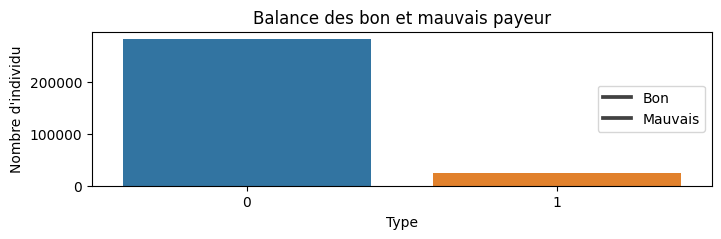

In [5]:
show_feature_balance(app_train["TARGET"])

Dataframe before undersampling, good client: 282686 bad client: 24825
Dataframe after undersampling, good client: 24825 bad client: 24825


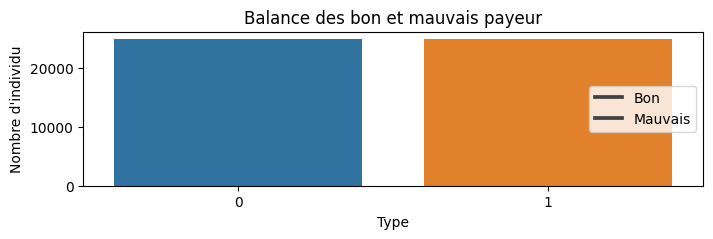

In [6]:

print(f"Dataframe before undersampling, good client: {len(app_train[app_train['TARGET'] == 0])} bad client: {len(app_train[app_train['TARGET'] == 1])}")
app_train = undersample_dataframe(app_train, "TARGET")
print(f"Dataframe after undersampling, good client: {len(app_train[app_train['TARGET'] == 0])} bad client: {len(app_train[app_train['TARGET'] == 1])}")
show_feature_balance(app_train["TARGET"])

Parmis les colonnes existantes, je préfère retirer toute colonnes qui ne sont pas éthiques pour éviter de potentiel bias dans les résultats.  
Je les retire des 2 fichiers.

In [7]:
# Removing unethical columns to remove bias
unethical_columns = [
    "CODE_GENDER", # Gender of the client
    "DAYS_BIRTH", # Client's age in days at the time of application
]

# Dropping unethical columns
app_train.drop(columns=unethical_columns, inplace=True)
app_test.drop(columns=unethical_columns, inplace=True)

app_train.head()

SK_ID_CURR  TARGET NAME_CONTRACT_TYPE FLAG_OWN_CAR FLAG_OWN_REALTY  \
0      333721       0         Cash loans            Y               Y   
1      110157       0    Revolving loans            N               Y   
2      276815       0    Revolving loans            Y               Y   
3      353213       0         Cash loans            Y               N   
4      447111       0         Cash loans            N               N   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             1          292500.0   1102500.0      32364.0        1102500.0   
1             0          270000.0    720000.0      36000.0         720000.0   
2             1          135000.0    360000.0      18000.0         360000.0   
3             0           90000.0    225000.0      10426.5         225000.0   
4             0          283500.0   1800000.0      51718.5        1800000.0   

   ... FLAG_DOCUMENT_18 FLAG_DOCUMENT_19 FLAG_DOCUMENT_20 FLAG_DOCUMENT_21  \
0  ...                0                0                0                0   
1  ...                0                0                0                0   
2  ...                0                0                0                0   
3  ...                0                0                0                0   
4  ...                0                0                0                0   

  AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                        0.0                        0.0   
1                        0.0                        0.0   
2                        0.0                        0.0   
3                        0.0                        0.0   
4                        0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        1.0   
2                         0.0                        0.0   
3                         0.0                        1.0   
4                         0.0                        1.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        0.0                         1.0  
1                        0.0                         2.0  
2                        0.0                         0.0  
3                        0.0                         6.0  
4                        0.0                         0.0  

[5 rows x 120 columns]

J'observe les types de mes différentes variables.

In [8]:
app_train.dtypes.value_counts()

float64    65
int64      40
object     15
dtype: int64

In [9]:
app_train.shape

(49650, 120)

Je remarque que j'ai 15 colonnes de type object, je vais surement devoir les encoder en fonction du nombre de valeurs unique.  
Je vais déjà stocker les colonnes de chaque type dans des variables différentes.

In [10]:
col_type_int64 = app_train.select_dtypes('int64').columns
col_type_float64 = app_train.select_dtypes('float64').columns
col_type_object = app_train.select_dtypes('object').columns

J'affiche les valeurs manquantes pour chaque type.

### Inspection du type Int64

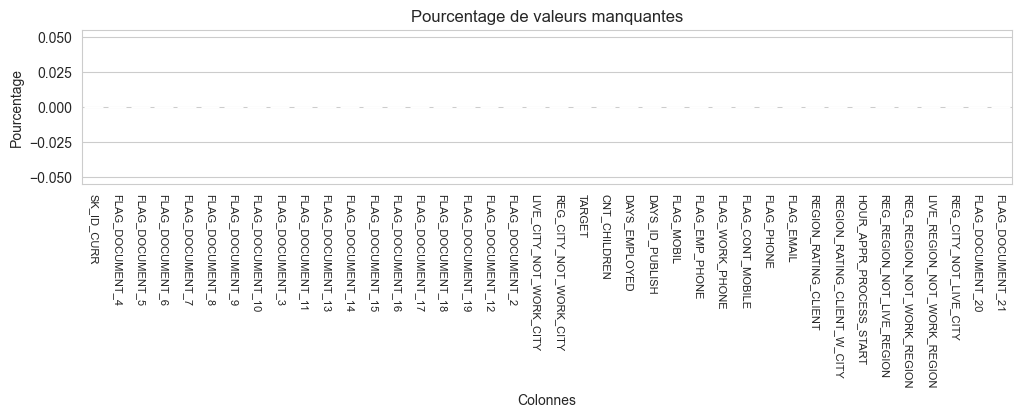

In [11]:
display_percentage_missing_chart(app_train[col_type_int64], 1)

Pas de valeurs manquantes pour les colonnes de type int64, je vais regarder les outliers

In [12]:
# Checking outliers for int64
pd.set_option("display.max_columns", None)
app_train[col_type_int64].describe()

SK_ID_CURR        TARGET  CNT_CHILDREN  DAYS_EMPLOYED  \
count   49650.000000  49650.000000  49650.000000   49650.000000   
mean   277717.259033      0.500000      0.440363   54030.646123   
std    102432.097063      0.500005      0.744236  132198.838853   
min    100002.000000      0.000000      0.000000  -17546.000000   
25%    189604.250000      0.000000      0.000000   -2475.000000   
50%    277331.500000      0.500000      0.000000   -1123.000000   
75%    366004.250000      1.000000      1.000000    -343.250000   
max    456255.000000      1.000000     19.000000  365243.000000   

       DAYS_ID_PUBLISH  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
count     49650.000000     49650.0    49650.000000     49650.000000   
mean      -2871.861329         1.0        0.847150         0.217140   
std        1514.582391         0.0        0.359846         0.412303   
min       -6274.000000         1.0        0.000000         0.000000   
25%       -4220.000000         1.0        1.000000         0.000000   
50%       -3036.000000         1.0        1.000000         0.000000   
75%       -1557.000000         1.0        1.000000         0.000000   
max           0.000000         1.0        1.000000         1.000000   

       FLAG_CONT_MOBILE    FLAG_PHONE    FLAG_EMAIL  REGION_RATING_CLIENT  \
count      49650.000000  49650.000000  49650.000000          49650.000000   
mean           0.998248      0.264270      0.056596              2.100967   
std            0.041824      0.440948      0.231072              0.512111   
min            0.000000      0.000000      0.000000              1.000000   
25%            1.000000      0.000000      0.000000              2.000000   
50%            1.000000      0.000000      0.000000              2.000000   
75%            1.000000      1.000000      0.000000              2.000000   
max            1.000000      1.000000      1.000000              3.000000   

       REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
count                 49650.000000             49650.000000   
mean                      2.079859                11.950796   
std                       0.506645                 3.269800   
min                       1.000000                 0.000000   
25%                       2.000000                10.000000   
50%                       2.000000                12.000000   
75%                       2.000000                14.000000   
max                       3.000000                23.000000   

       REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
count                49650.000000                49650.000000   
mean                     0.016757                    0.053051   
std                      0.128362                    0.224138   
min                      0.000000                    0.000000   
25%                      0.000000                    0.000000   
50%                      0.000000                    0.000000   
75%                      0.000000                    0.000000   
max                      1.000000                    1.000000   

       LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
count                 49650.000000            49650.000000   
mean                      0.041047                0.096737   
std                       0.198402                0.295603   
min                       0.000000                0.000000   
25%                       0.000000                0.000000   
50%                       0.000000                0.000000   
75%                       0.000000                0.000000   
max                       1.000000                1.000000   

       REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  FLAG_DOCUMENT_2  \
count            49650.000000             49650.000000     49650.000000   
mean                 0.264250                 0.198691         0.000081   
std                  0.440937                 0.399019         0.008975   
min                  0.000000                 0.000000     

J'observe que les colonnes DAYS_EMPLOYED et DAYS_ID_PUBLISH on des valeurs négatives.
Concernant le reste, c'est souvent binaire.

Pour rappel des descriptions:  
	- **DAYS_EMPLOYED**   = `How many days before the application the person started current employment`  
 	- **DAYS_ID_PUBLISH** = `How many days before the application did client change the identity document with which he applied for the loan`

Pour DAYS_EMPLOYED, j'affiche un graphique de distribution des jours employés

#### Résultat

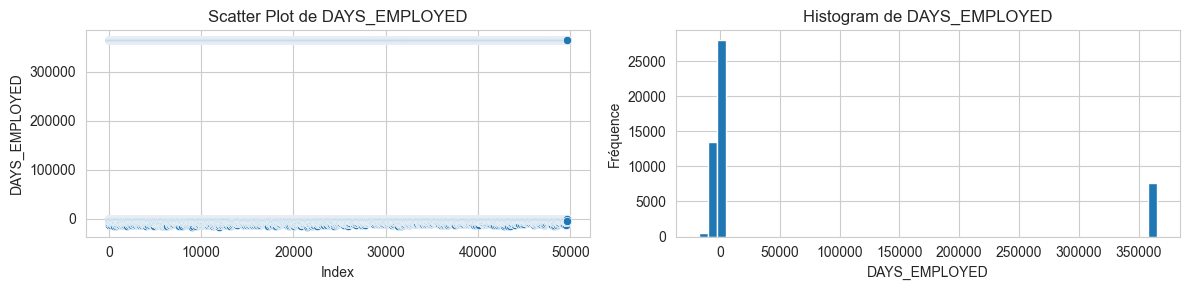

In [13]:
display_scatter_and_hist_graph_for_column(app_train,"DAYS_EMPLOYED")

Je remarque que +50k valeurs sont égales à 365243.  
Ça m'a l'air d'être une erreur, on ne peut pas être employé 1000ans après avoir fait le demande de crédit, lors de la demande.  
Dans ce cas, je vais les remplacer par NaN pour continuer mon analyse sans bias.

In [14]:
app_train[app_train['DAYS_EMPLOYED'] >= 0]['DAYS_EMPLOYED'].value_counts()
print(f"DAYS_EMPLOYED a {app_train['DAYS_EMPLOYED'].isna().sum()} valeurs NaN")

app_train['DAYS_EMPLOYED'].replace({365243: np.NaN}, inplace = True)
app_test['DAYS_EMPLOYED'].replace({365243: np.NaN}, inplace = True)

# app_train['DAYS_EMPLOYED'].replace({365243: -1}, inplace = True)
# app_train['DAYS_EMPLOYED'].replace({365243: 0}, inplace = True)

print(f"DAYS_EMPLOYED a maintenant {app_train['DAYS_EMPLOYED'].isna().sum()} valeurs NaN")

DAYS_EMPLOYED a 0 valeurs NaN
DAYS_EMPLOYED a maintenant 7588 valeurs NaN


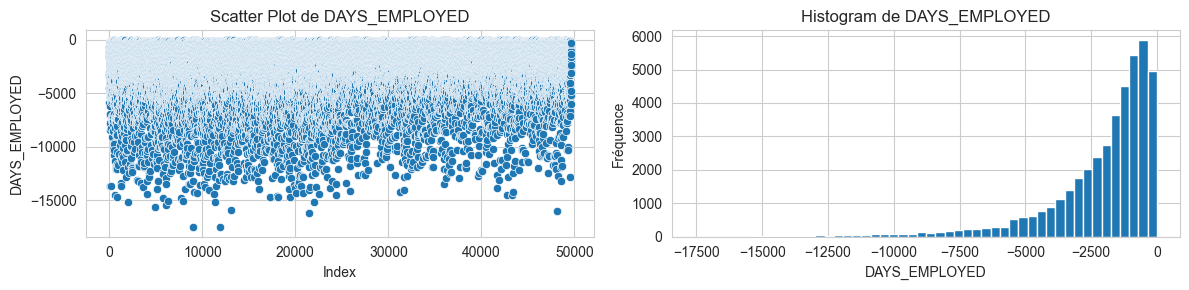

In [15]:
display_scatter_and_hist_graph_for_column(app_train,"DAYS_EMPLOYED")

Ok ça me parait mieux pour effectuer mon analyse et feature engineering.  
Je vais maintenant observer l'autre colonne DAYS_ID_PUBLISH

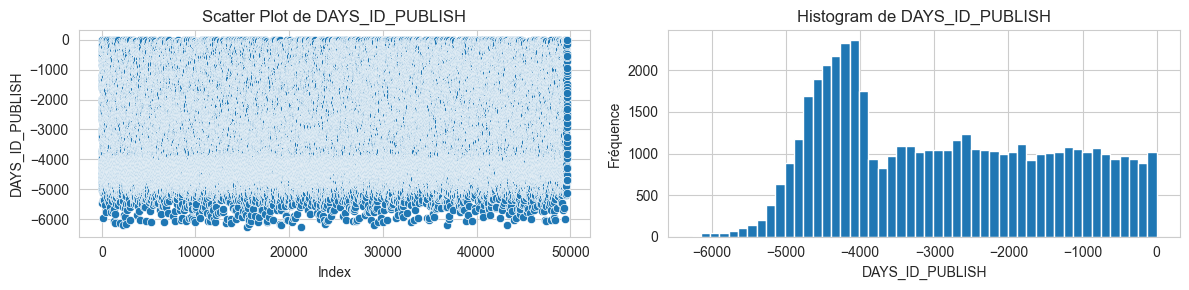

In [16]:
display_scatter_and_hist_graph_for_column(app_train,"DAYS_ID_PUBLISH")

Pas de valeurs positives, ça me rassure.

### Inspection du type Object

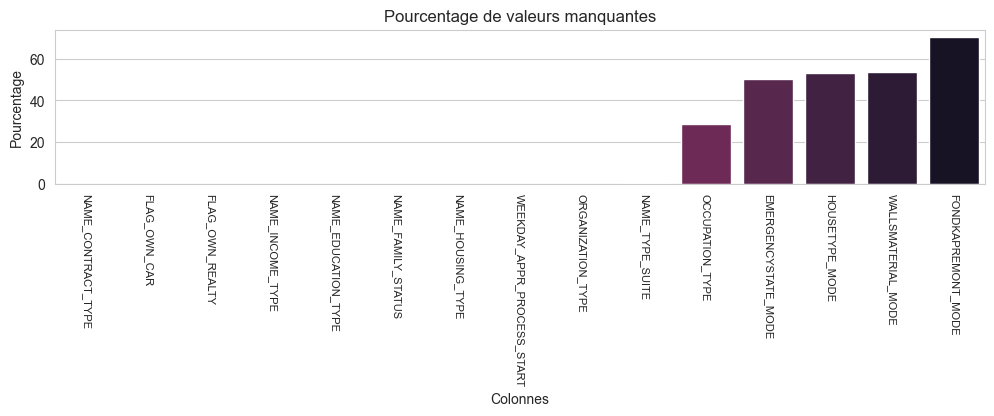

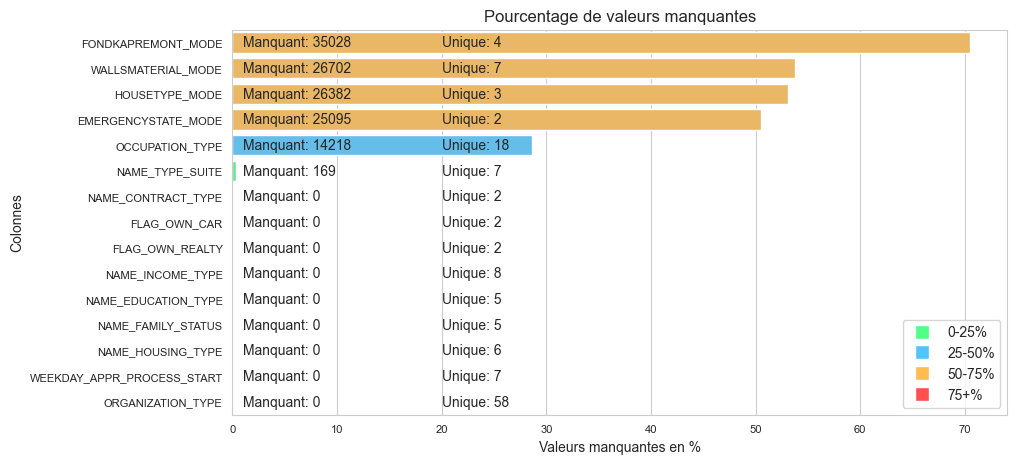

In [17]:
display_percentage_missing_chart(app_train[col_type_object], 1)
display_graph_missing_data(app_train[col_type_object], 5)

Dans ce cas de figure, n'ayant peu de colonnes unique je vais transdformer les colonnes de type object en int64 afin de pouvoir les étudier. 

Je vais utiliser deux méthodes comme défini dans le [kaggle d'exemple fourni](https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction): 

- **Label Encoder** : Pour les colonnes qui n'ont que 2 valeurs (afin d'avoir un 1 ou 0),
- **One-Hot encoding**: Pour les colonnes qui ont plus que 2 valeurs, créer une colonnes en plus par valeur unique.

In [18]:
# Label encode object (<= unique type > Label encoder
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # print(
        unique_vals = list(app_train[col].unique())
                 
        if len(unique_vals) <= 2.0:
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col].map(lambda x: x if x in unique_vals else np.nan))
            app_test[col] = le.transform(app_test[col].map(lambda x: x if x in unique_vals else 0))
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d colonnes transformées avec la méthode "label encoded".' % le_count)

3 colonnes transformées avec la méthode "label encoded".


In [19]:
# One-hot encoding for feature with > 2 unique values
print('app_train avant one-hot encoding: ', app_train.shape)
print('app_test avant one-hot encoding: ', app_test.shape)

# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('\napp_train après one-hot encoding: ', app_train.shape)
print('app_test après one-hot encoding: ', app_test.shape)

app_train avant one-hot encoding:  (49650, 120)
app_test avant one-hot encoding:  (48744, 119)

app_train après one-hot encoding:  (49650, 238)
app_test après one-hot encoding:  (48744, 236)


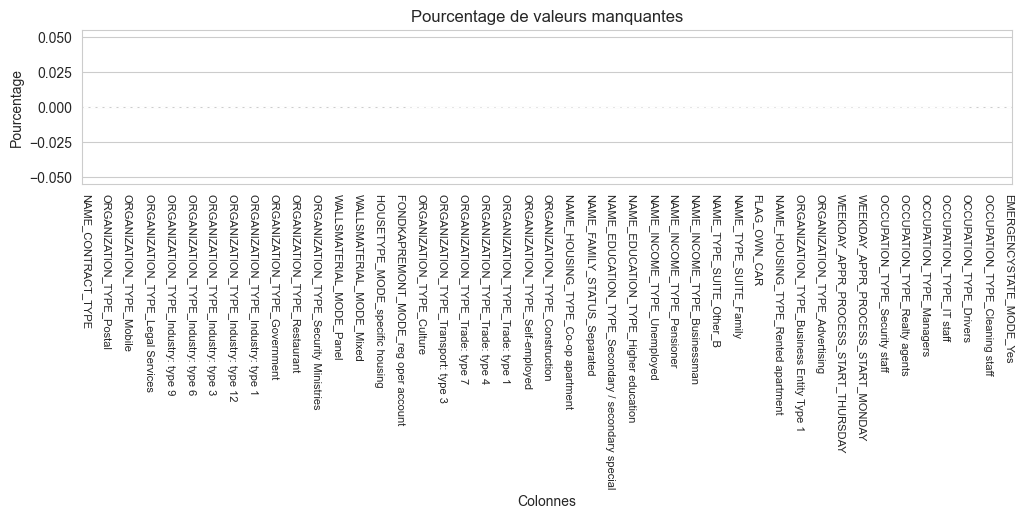

In [20]:
test_data = app_train.drop(columns=col_type_int64).drop(columns=col_type_float64)
display_percentage_missing_chart(test_data, 3)

Comme prévu, pas de valeurs manquantes.

### Inspection du type Float64

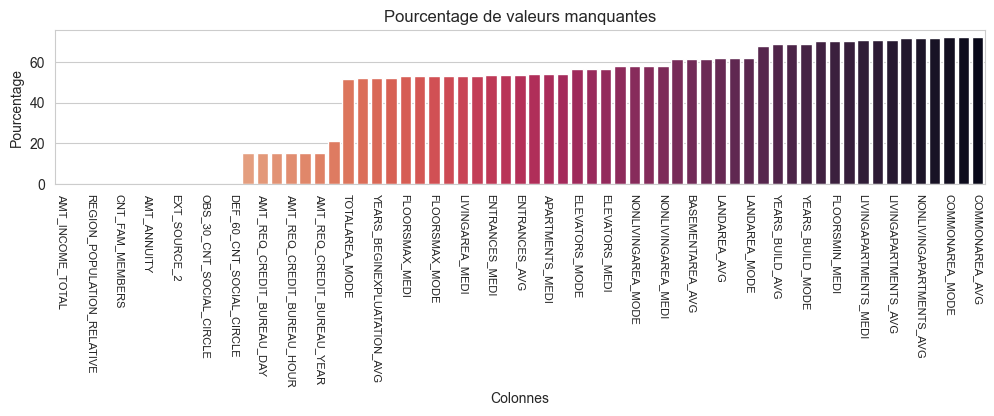

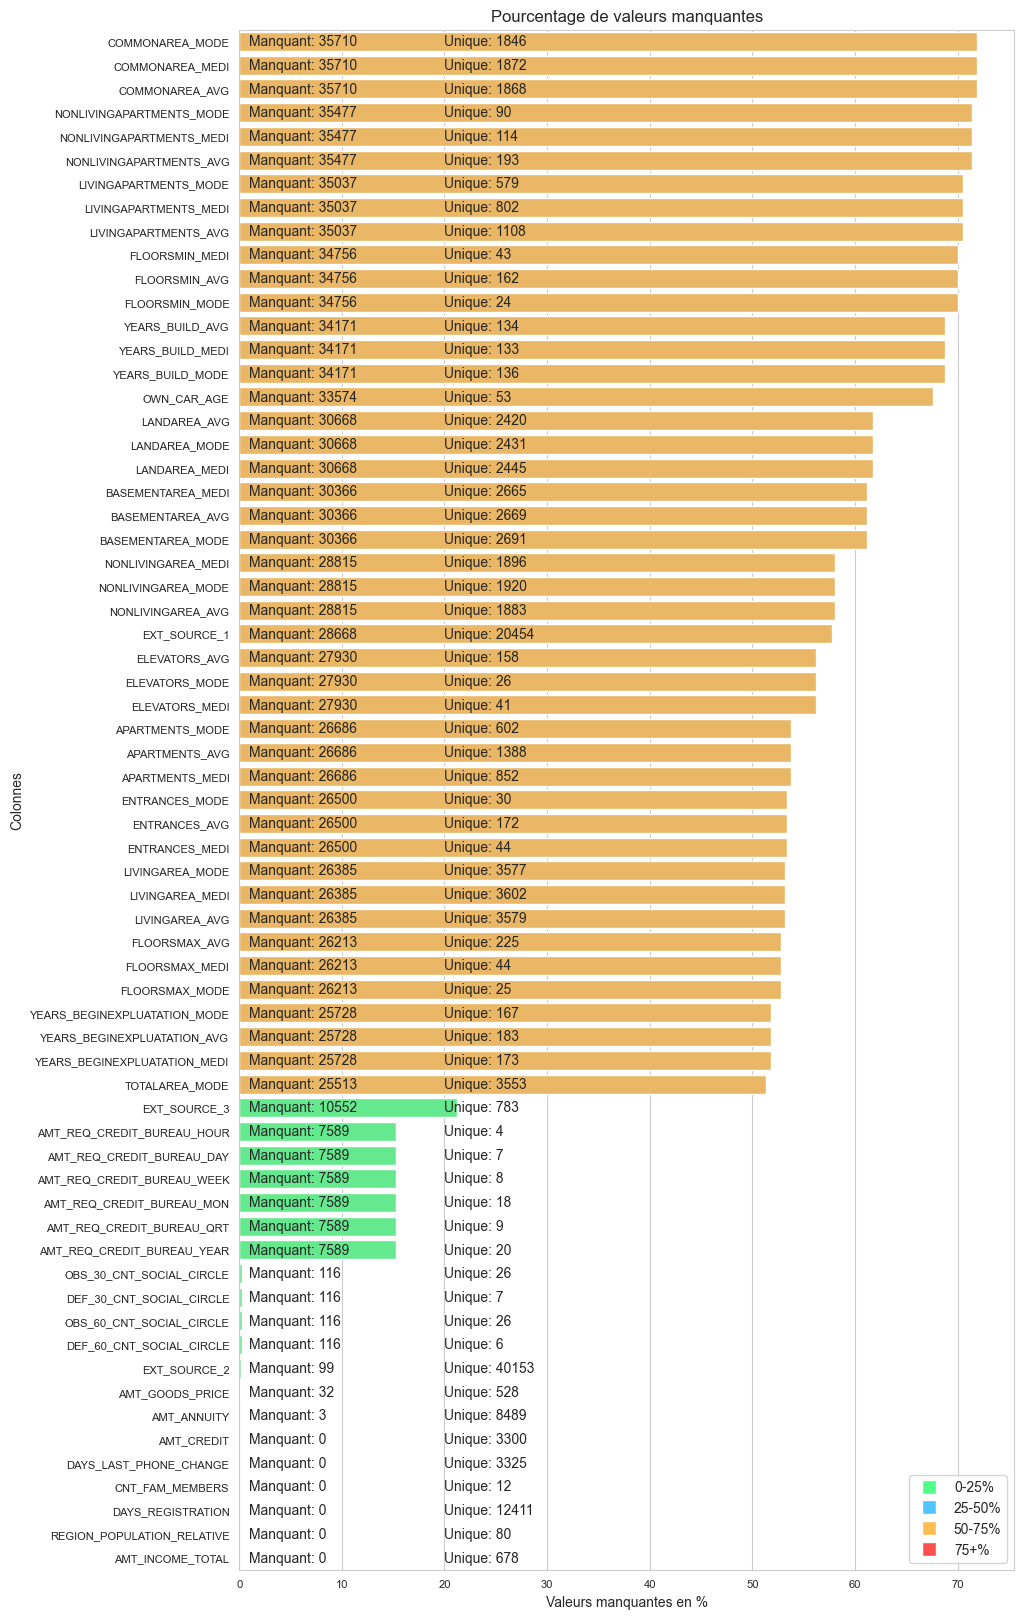

In [21]:
display_percentage_missing_chart(app_train[col_type_float64], 2)
display_graph_missing_data(app_train[col_type_float64], 20)

Beaucoup de valeurs manquantes.  
Je commence par observer les valeurs abérrantes

In [22]:
app_train[col_type_float64].describe()

AMT_INCOME_TOTAL    AMT_CREDIT    AMT_ANNUITY  AMT_GOODS_PRICE  \
count      4.965000e+04  4.965000e+04   49647.000000     4.961800e+04   
mean       1.672573e+05  5.810548e+05   26860.745997     5.166760e+05   
std        5.323051e+05  3.792225e+05   13648.762610     3.456790e+05   
min        2.565000e+04  4.500000e+04    2722.500000     4.500000e+04   
25%        1.125000e+05  2.762775e+05   16875.000000     2.385000e+05   
50%        1.440000e+05  5.084955e+05   25173.000000     4.500000e+05   
75%        2.025000e+05  7.819200e+05   33907.500000     6.750000e+05   
max        1.170000e+08  4.027680e+06  225000.000000     3.600000e+06   

       REGION_POPULATION_RELATIVE  DAYS_REGISTRATION   OWN_CAR_AGE  \
count                49650.000000       49650.000000  16076.000000   
mean                     0.020063       -4756.263907     12.768661   
std                      0.013066        3430.919181     12.246942   
min                      0.000533      -22928.000000      0.000000   
25%                      0.009657       -7109.000000      6.000000   
50%                      0.018801       -4299.000000     10.000000   
75%                      0.026392       -1849.000000     16.000000   
max                      0.072508           0.000000     91.000000   

       CNT_FAM_MEMBERS  EXT_SOURCE_1  EXT_SOURCE_2  EXT_SOURCE_3  \
count     49650.000000  20982.000000  49551.000000  39098.000000   
mean          2.167956      0.453112      0.467174      0.457038   
std           0.934268      0.216361      0.207702      0.208290   
min           1.000000      0.014691      0.000005      0.000527   
25%           2.000000      0.274428      0.309064      0.294083   
50%           2.000000      0.441926      0.516708      0.468660   
75%           3.000000      0.626464      0.636959      0.627991   
max          20.000000      0.942333      0.855000      0.896010   

       APARTMENTS_AVG  BASEMENTAREA_AVG  YEARS_BEGINEXPLUATATION_AVG  \
count    22964.000000      19284.000000                 23922.000000   
mean         0.112537          0.085455                     0.976920   
std          0.105483          0.080411                     0.063025   
min          0.000000          0.000000                     0.000000   
25%          0.051500          0.041600                     0.976200   
50%          0.082500          0.074500                     0.981600   
75%          0.143300          0.109500                     0.986600   
max          1.000000          1.000000                     1.000000   

       YEARS_BUILD_AVG  COMMONAREA_AVG  ELEVATORS_AVG  ENTRANCES_AVG  \
count     15479.000000    13940.000000   21720.000000   23150.000000   
mean          0.748318        0.042315       0.071235       0.146094   
std           0.114240        0.074107       0.128012       0.098196   
min           0.000000        0.000000       0.000000       0.000000   
25%           0.687200        0.007500       0.000000       0.069000   
50%           0.748400        0.019700       0.000000       0.137900   
75%           0.816400        0.048400       0.120000       0.206900   
max           1.000000        1.000000       1.000000       1.000000   

       FLOORSMAX_AVG  FLOORSMIN_AVG  LANDAREA_AVG  LIVINGAPARTMENTS_AVG  \
count   23437.000000   14894.000000  18982.000000          14613.000000   
mean        0.216684       0.222950      0.064560              0.096647   
std         0.140730       0.156087      0.080838              0.090847   
min         0.000000       0.000000      0.000000              0.000000   
25%         0.166700       0.083300      0.018300              0.049200   
50%         0.166700       0.208300      0.046600              0.072700   
75%         0.333300       0.375000      0.083600              0.120200   
max         1.000000       1.000000      1.000000              1.000000   

       LIVINGAREA_AVG  NONLIVINGAPARTMENTS_AVG  NONLIVINGAREA_AVG  \
count    23265.000000             14173.000000       20835.000

Je ne vois pas de valeurs abérrantes, je vais continuer pas observer de features puis je remplacerai les valeurs manquantes

### Observation des features pertinentes

Pour améliorer la detection de correlations et les entrainements de modèles, je vais normaliser les features dans un autre tableau. (Détails dans la description des colonnes)

Je vais maintenant remplacer les valeurs manquantes par différentes méthodes pour analyser le meilleur comportement.
- Suppression total des valeurs manquantes
- Remplacement des valeurs manquantes par la moyenne
- Remplacement des valeurs manquantes par la médiane
- Remplacement des valeurs manquantes par 0

Je vérifie maintenant les correlations entre les features pour voir si je peux réduire en dimension mon dataframe.

#### Résultat

#### Corrélations avec TARGET

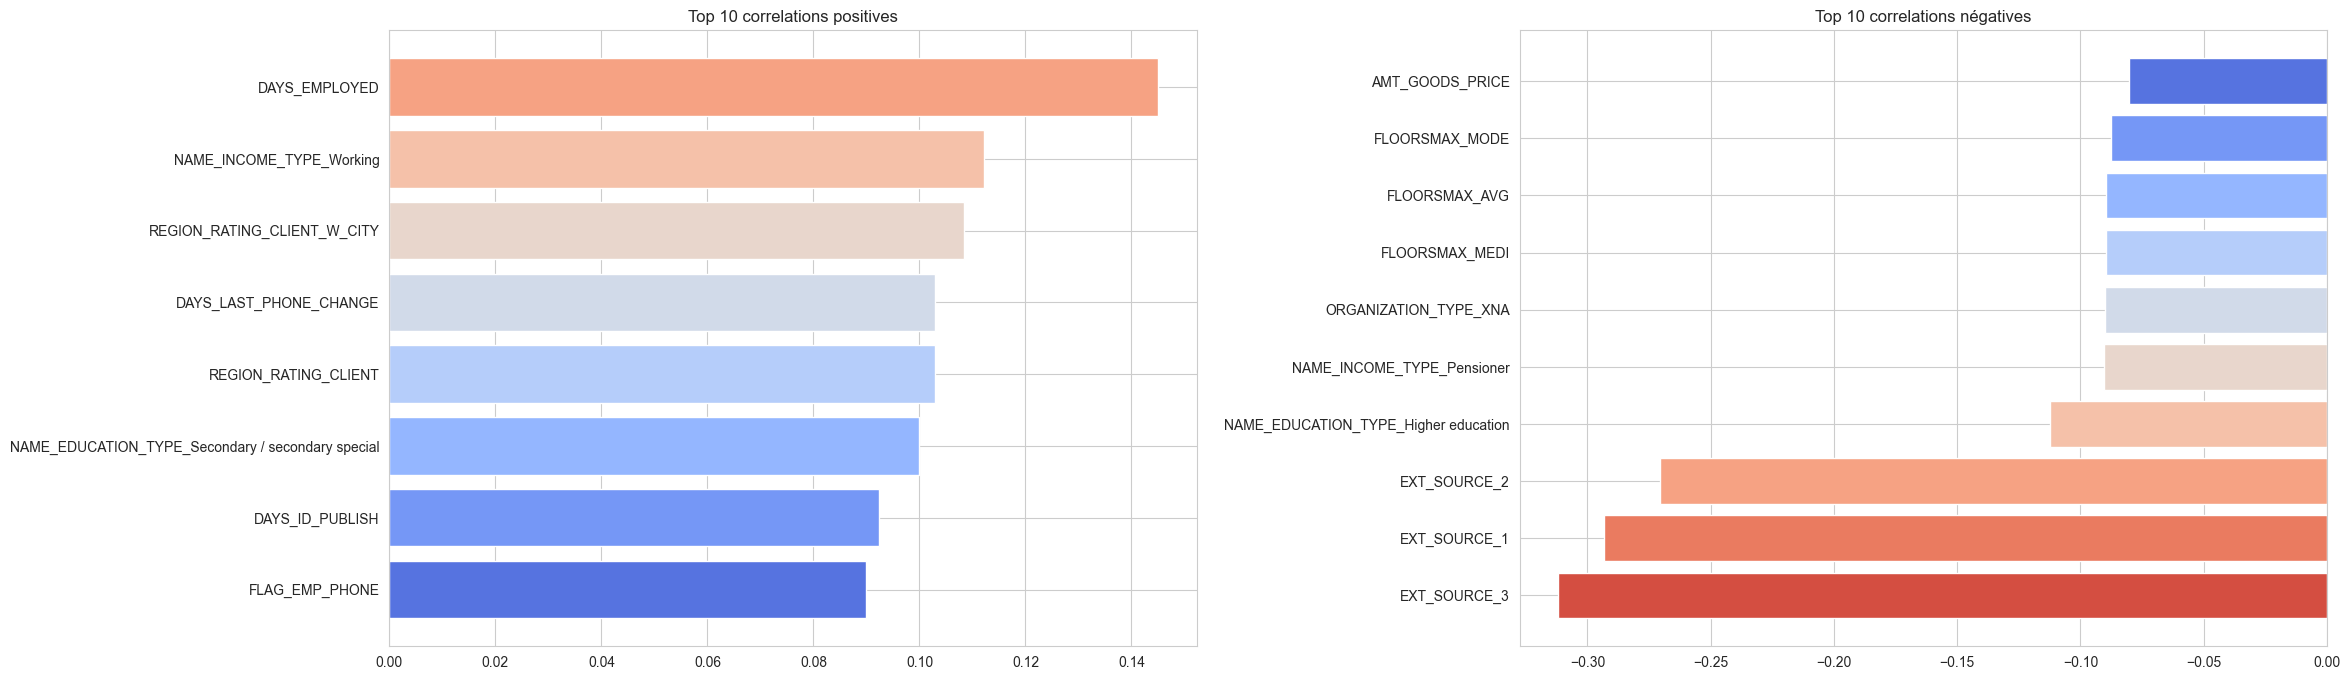

In [23]:
corr = get_target_correlations(app_train)

In [24]:
app_train.shape

(49650, 238)

In [25]:
df_functions = {  
    "sum_living_features": test_sum_living_features,  
    "sum_flag_documents": test_sum_flag_documents,  
    "sum_flag_contacts": test_sum_flag_contacts,
    "sum_flag_living_contact": lambda df: test_sum_flag_contacts(test_sum_flag_documents(test_sum_living_features(df)))  
}

all_data = {}

all_data["default"] = {}  
all_data["default"]["df"] = app_train.copy()
all_data["default"]["test_df"] = app_test.copy()
print(f"Dataframe default shape = {all_data['default']['df'].shape}")
    
for df_name, func in df_functions.items():  
    all_data[df_name] = {}  
    all_data[df_name]["df"] = func(app_train)  
    all_data[df_name]["test_df"] = func(app_test)  
    print(f"Dataframe {df_name} shape = {all_data[df_name]['df'].shape}")

Dataframe default shape = (49650, 238)
Dataframe sum_living_features shape = (49650, 196)
Dataframe sum_flag_documents shape = (49650, 219)
Dataframe sum_flag_contacts shape = (49650, 233)
Dataframe sum_flag_living_contact shape = (49650, 172)


In [26]:
corr_sum_living_features = get_target_correlations(all_data["sum_living_features"]["df"], False)
corr_sum_flag_documents = get_target_correlations(all_data["sum_flag_documents"]["df"], False)
corr_sum_flag_contacts = get_target_correlations(all_data["sum_flag_contacts"]["df"], False)

In [27]:
print("Correlation sum_living_features: ", corr_sum_living_features["sum_living_features"]["TARGET"])
print("Correlation sum_flag_documents: ", corr_sum_flag_documents["sum_flag_documents"]["TARGET"])
print("Correlation sum_flag_contact: ", corr_sum_flag_contacts["sum_flag_contacts"]["TARGET"])

Correlation sum_living_features:  -0.08768598415555698
Correlation sum_flag_documents:  0.03582703948944531
Correlation sum_flag_contact:  0.03800064141904698


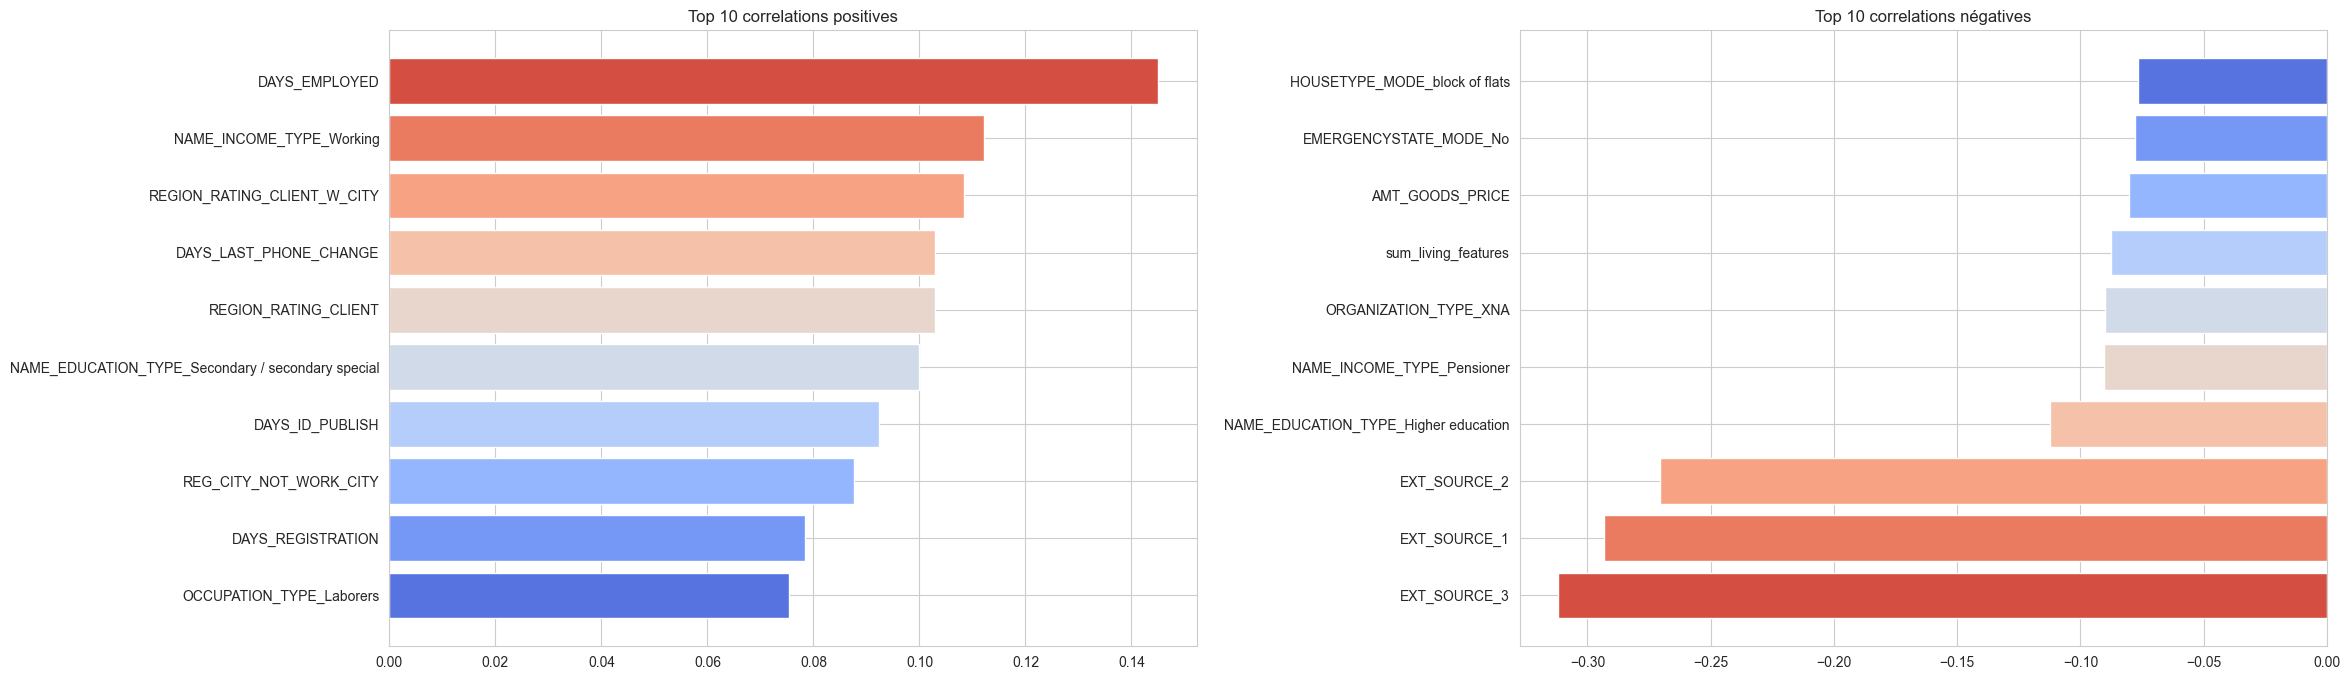

In [28]:
corr_sum_flag_living_contact = get_target_correlations(all_data["sum_flag_living_contact"]["df"])

#### Mutual informations

In [29]:
mi_scores_default = make_mi_scores_class(all_data["default"]["df"].drop("TARGET", axis=1), all_data["default"]["df"]["TARGET"])
mi_scores_sum_flag_living_contact = make_mi_scores_class(all_data["sum_flag_living_contact"]["df"].drop("TARGET", axis=1), all_data["sum_flag_living_contact"]["df"]["TARGET"])

KeyboardInterrupt: 

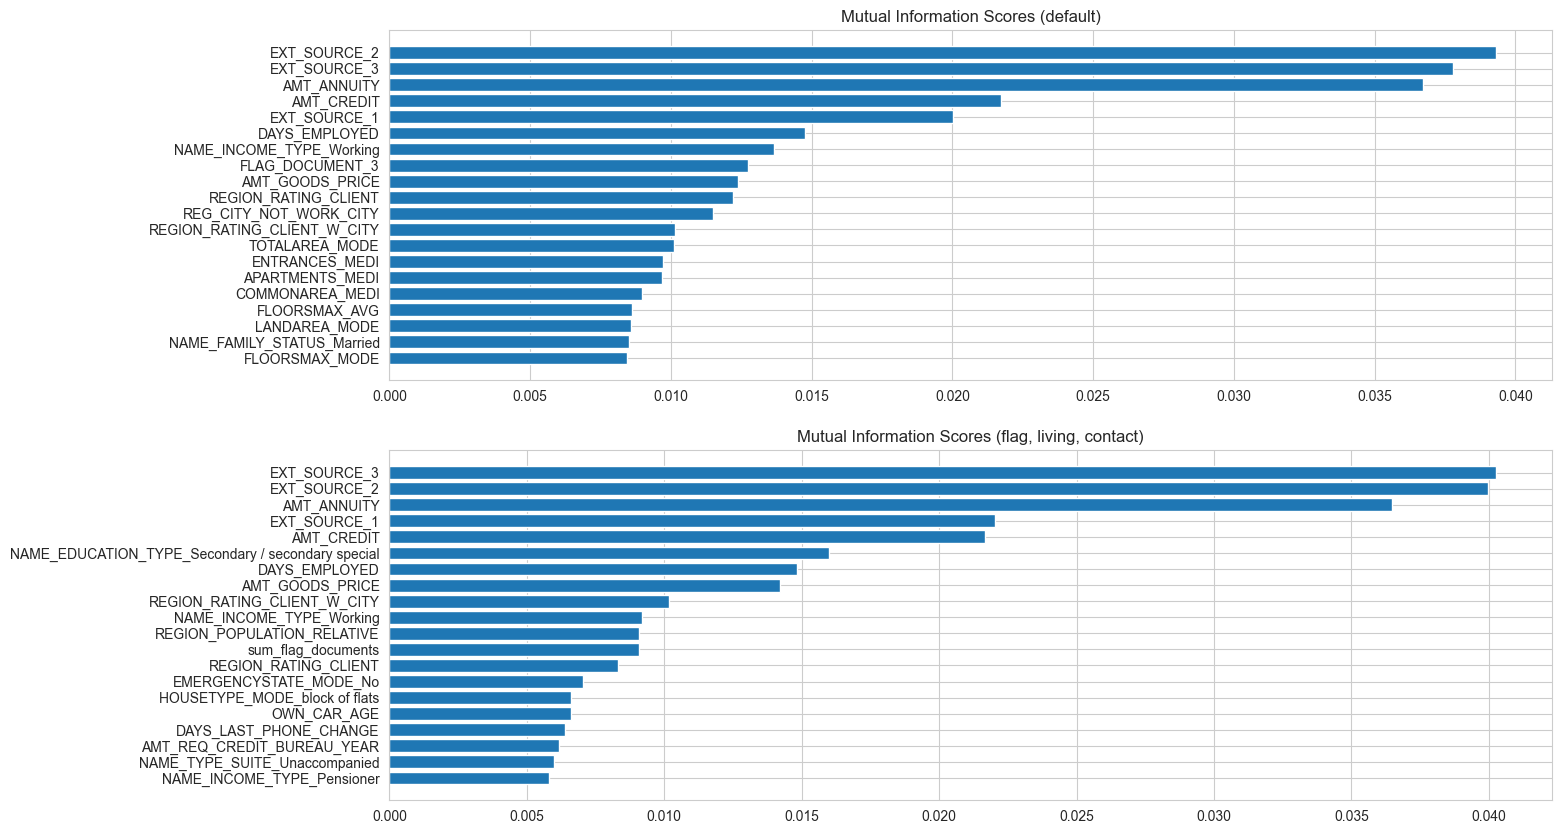

In [ ]:
fix, axs = plt.subplots(2, 1, figsize=(15, 10))
plot_mi_scores(mi_scores_default[:20],axs[0],"Mutual Information Scores (default)")
plot_mi_scores(mi_scores_sum_flag_living_contact[:20], axs[1],"Mutual Information Scores (flag, living, contact)")

### Feature Engineering

Prepare all models

In [ ]:
# Copying the data because the normalization will add more keys
copied_all_data = all_data.copy()

# Loop trhough all and normalize them
for data_name in copied_all_data.keys():
    print(f"Normalizing {data_name} dataframes (per columns & all columns)...")

    # Data that won't be normalized
    target = all_data[data_name]["df"]["TARGET"].copy()
    ident = all_data[data_name]["df"]["SK_ID_CURR"].copy()
    test_ident = all_data[data_name]["test_df"]["SK_ID_CURR"].copy()

    # Per columns
    norm_col_name = f"{data_name}_norm_col"
    all_data[norm_col_name] = {}
    all_data[norm_col_name]["df"] = normalize_per_col(all_data[data_name]["df"].drop(columns=["TARGET", "SK_ID_CURR"]))
    all_data[norm_col_name]["test_df"] = normalize_per_col(all_data[data_name]["test_df"].drop(columns=["SK_ID_CURR"]))
    
    all_data[norm_col_name]["df"].insert(all_data[data_name]["df"].columns.get_loc(ident.name), ident.name, ident)
    all_data[norm_col_name]["df"].insert(all_data[data_name]["df"].columns.get_loc(target.name), target.name, target)
    all_data[norm_col_name]["test_df"].insert(all_data[data_name]["test_df"].columns.get_loc(test_ident.name), test_ident.name, test_ident)
    
    
    # All columns
    norm_all_name = f"{data_name}_norm_all"
    all_data[norm_all_name] = {}
    all_data[norm_all_name]["df"] = normalize_all_col(all_data[data_name]["df"].drop(columns=["TARGET", "SK_ID_CURR"]))
    all_data[norm_all_name]["test_df"] = normalize_all_col(all_data[data_name]["test_df"].drop(columns=["SK_ID_CURR"]))

    all_data[norm_all_name]["df"].insert(all_data[data_name]["df"].columns.get_loc(ident.name), ident.name, ident)
    all_data[norm_all_name]["df"].insert(all_data[data_name]["df"].columns.get_loc(target.name), target.name, target)
    all_data[norm_all_name]["test_df"].insert(all_data[data_name]["test_df"].columns.get_loc(test_ident.name), test_ident.name, test_ident)
    

print("Done")

Normalizing default dataframes (per columns & all columns)...
Normalizing sum_living_features dataframes (per columns & all columns)...
Normalizing sum_flag_documents dataframes (per columns & all columns)...
Normalizing sum_flag_contacts dataframes (per columns & all columns)...
Normalizing sum_flag_living_contact dataframes (per columns & all columns)...
Done


In [ ]:
all_data["default_norm_all"]["df"].head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      333721       0            0.000196      0.000196         0.000196   
1      110157       0            0.000196      0.000196         0.000196   
2      276815       0            0.000196      0.000196         0.000196   
3      353213       0            0.000196      0.000196         0.000196   
4      447111       0            0.000196      0.000196         0.000196   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0      0.000196          0.002695    0.009617     0.000472         0.009617   
1      0.000196          0.002503    0.006349     0.000504         0.006349   
2      0.000196          0.001350    0.003272     0.000350         0.003272   
3      0.000196          0.000965    0.002119     0.000285         0.002119   
4      0.000196          0.002619    0.015578     0.000638         0.015578   

   REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.000196       0.000190           0.000192   
1                    0.000196            NaN           0.000159   
2                    0.000196       0.000167           0.000157   
3                    0.000196       0.000186           0.000155   
4                    0.000196       0.000168           0.000180   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         0.000168     0.000196    0.000196        0.000196         0.000196   
1         0.000160          NaN    0.000196        0.000196         0.000196   
2         0.000174     0.000196    0.000196        0.000196         0.000196   
3         0.000170     0.000196    0.000196        0.000196         0.000196   
4         0.000159          NaN    0.000196        0.000196         0.000196   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0          0.000196    0.000196    0.000196         0.000196   
1          0.000196    0.000196    0.000196         0.000196   
2          0.000196    0.000196    0.000196         0.000196   
3          0.000196    0.000196    0.000196         0.000196   
4          0.000196    0.000196    0.000196         0.000196   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0              0.000196                     0.000196                 0.000196   
1              0.000196                     0.000196                 0.000196   
2              0.000196                     0.000196                 0.000196   
3              0.000196                     0.000196                 0.000196   
4              0.000196                     0.000196                 0.000196   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                    0.000196                    0.000196   
1                    0.000196                    0.000196   
2                    0.000196                    0.000196   
3                    0.000196                    0.000196   
4                    0.000196                    0.000196   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                     0.000196                0.000196   
1                     0.000196                0.000196   
2                     0.000196                0.000196   
3                     0.000196                0.000196   
4                     0.000196                0.000196   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                0.000196                 0.000196           NaN   
1                0.000196                 0.000196           NaN   
2                0.000196                 0.000196      0.000196   
3                0.000196                 0.000196      0.000196   
4                0.000196                 0.000196      0.000196   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.000196      0.000196        0.000196          0.000196   
1      0.000196      0.000196        0.000196          0

In [ ]:
all_data["default_norm_col"]["df"].head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      333721       0                 0.0           1.0              1.0   
1      110157       0                 1.0           0.0              1.0   
2      276815       0                 1.0           1.0              1.0   
3      353213       0                 0.0           1.0              0.0   
4      447111       0                 0.0           0.0              0.0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0      0.052632          0.002281    0.265525     0.133354         0.297468   
1      0.000000          0.002089    0.169484     0.149712         0.189873   
2      0.052632          0.000935    0.079092     0.068732         0.088608   
3      0.000000          0.000550    0.045196     0.034659         0.050633   
4      0.000000          0.002204    0.440658     0.220427         0.493671   

   REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.245585       0.960789           0.978193   
1                    0.634762            NaN           0.814027   
2                    0.144953       0.804400           0.802687   
3                    0.204071       0.934230           0.792132   
4                    0.041792       0.814431           0.916565   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         0.470035     0.098901         0.0             1.0              0.0   
1         0.338381          NaN         0.0             0.0              0.0   
2         0.592286     0.076923         0.0             1.0              0.0   
3         0.515939     0.076923         0.0             1.0              0.0   
4         0.316863          NaN         0.0             1.0              0.0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0               1.0         1.0         0.0         0.105263   
1               1.0         0.0         0.0         0.052632   
2               1.0         0.0         1.0         0.052632   
3               1.0         1.0         0.0         0.000000   
4               1.0         0.0         0.0         0.052632   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                   1.0                          1.0                 0.391304   
1                   0.0                          0.0                 0.434783   
2                   0.5                          0.5                 0.565217   
3                   0.5                          0.5                 0.782609   
4                   0.0                          0.0                 0.434783   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                          0.0                     0.0   
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     0.0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                     0.0                      0.0           NaN   
1                     0.0                      0.0           NaN   
2                     0.0                      0.0      0.852582   
3                     1.0                      1.0      0.594469   
4                     0.0                      0.0      0.470608   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.720686      0.726684          0.2938            0.1995   
1      0.852046      0.711925          0.0763           

In [ ]:
all_data["default"]["df"].head()

SK_ID_CURR  TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  \
0      333721       0                   0             1                1   
1      110157       0                   1             0                1   
2      276815       0                   1             1                1   
3      353213       0                   0             1                0   
4      447111       0                   0             0                0   

   CNT_CHILDREN  AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0             1          292500.0   1102500.0      32364.0        1102500.0   
1             0          270000.0    720000.0      36000.0         720000.0   
2             1          135000.0    360000.0      18000.0         360000.0   
3             0           90000.0    225000.0      10426.5         225000.0   
4             0          283500.0   1800000.0      51718.5        1800000.0   

   REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018209         -688.0             -500.0   
1                    0.046220            NaN            -4264.0   
2                    0.010966        -3432.0            -4524.0   
3                    0.015221        -1154.0            -4766.0   
4                    0.003541        -3256.0            -1913.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -3325          9.0           1               1                0   
1            -4151          NaN           1               0                0   
2            -2558          7.0           1               1                0   
3            -3037          7.0           1               1                0   
4            -4286          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              3.0   
1                 1           0           0              2.0   
2                 1           0           1              2.0   
3                 1           1           0              1.0   
4                 1           0           0              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     3                            3                        9   
1                     1                            1                       10   
2                     2                            2                       13   
3                     2                            2                       18   
4                     1                            1                       10   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0           NaN   
1                       0                        0           NaN   
2                       0                        0      0.805582   
3                       1                        1      0.566146   
4                       0                        0      0.451247   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.616187      0.651260          0.2938            0.1995   
1      0.728499      0.638044          0.0763           

In [ ]:
# Prepare all dataFrames for feature engineering
for data_name in all_data.keys():
    print(f"Preparing {data_name}...")
    all_data[data_name] = prepare_dataFrame_for_feature_engineering(all_data[data_name])
print("Done")

Preparing default...
Preparing sum_living_features...
Preparing sum_flag_documents...
Preparing sum_flag_contacts...
Preparing sum_flag_living_contact...
Preparing default_norm_col...
Preparing default_norm_all...
Preparing sum_living_features_norm_col...
Preparing sum_living_features_norm_all...
Preparing sum_flag_documents_norm_col...
Preparing sum_flag_documents_norm_all...
Preparing sum_flag_contacts_norm_col...
Preparing sum_flag_contacts_norm_all...
Preparing sum_flag_living_contact_norm_col...
Preparing sum_flag_living_contact_norm_all...
Done


In [ ]:
all_data["default"]["df"].head()

TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0       0                   0             1                1             1   
1       0                   1             0                1             0   
2       0                   1             1                1             1   
3       0                   0             1                0             0   
4       0                   0             0                0             0   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          292500.0   1102500.0      32364.0        1102500.0   
1          270000.0    720000.0      36000.0         720000.0   
2          135000.0    360000.0      18000.0         360000.0   
3           90000.0    225000.0      10426.5         225000.0   
4          283500.0   1800000.0      51718.5        1800000.0   

   REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.018209         -688.0             -500.0   
1                    0.046220            NaN            -4264.0   
2                    0.010966        -3432.0            -4524.0   
3                    0.015221        -1154.0            -4766.0   
4                    0.003541        -3256.0            -1913.0   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0            -3325          9.0           1               1                0   
1            -4151          NaN           1               0                0   
2            -2558          7.0           1               1                0   
3            -3037          7.0           1               1                0   
4            -4286          NaN           1               1                0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0                 1           1           0              3.0   
1                 1           0           0              2.0   
2                 1           0           1              2.0   
3                 1           1           0              1.0   
4                 1           0           0              2.0   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                     3                            3                        9   
1                     1                            1                       10   
2                     2                            2                       13   
3                     2                            2                       18   
4                     1                            1                       10   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                           0                           0   
1                           0                           0   
2                           0                           0   
3                           0                           0   
4                           0                           0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                            0                       0   
1                            0                       0   
2                            0                       0   
3                            0                       0   
4                            0                       0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                       0                        0           NaN   
1                       0                        0           NaN   
2                       0                        0      0.805582   
3                       1                        1      0.566146   
4                       0                        0      0.451247   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.616187      0.651260          0.2938            0.1995   
1      0.728499      0.638044          0.0763            0.0603   
2      0.667953      0.108226          0.2361            0.17

In [ ]:
all_data["default_norm_col"]["df"].head()

TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0       0                 0.0           1.0              1.0      0.052632   
1       0                 1.0           0.0              1.0      0.000000   
2       0                 1.0           1.0              1.0      0.052632   
3       0                 0.0           1.0              0.0      0.000000   
4       0                 0.0           0.0              0.0      0.000000   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          0.002281    0.265525     0.133354         0.297468   
1          0.002089    0.169484     0.149712         0.189873   
2          0.000935    0.079092     0.068732         0.088608   
3          0.000550    0.045196     0.034659         0.050633   
4          0.002204    0.440658     0.220427         0.493671   

   REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.245585       0.960789           0.978193   
1                    0.634762            NaN           0.814027   
2                    0.144953       0.804400           0.802687   
3                    0.204071       0.934230           0.792132   
4                    0.041792       0.814431           0.916565   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         0.470035     0.098901         0.0             1.0              0.0   
1         0.338381          NaN         0.0             0.0              0.0   
2         0.592286     0.076923         0.0             1.0              0.0   
3         0.515939     0.076923         0.0             1.0              0.0   
4         0.316863          NaN         0.0             1.0              0.0   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0               1.0         1.0         0.0         0.105263   
1               1.0         0.0         0.0         0.052632   
2               1.0         0.0         1.0         0.052632   
3               1.0         1.0         0.0         0.000000   
4               1.0         0.0         0.0         0.052632   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0                   1.0                          1.0                 0.391304   
1                   0.0                          0.0                 0.434783   
2                   0.5                          0.5                 0.565217   
3                   0.5                          0.5                 0.782609   
4                   0.0                          0.0                 0.434783   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                          0.0                     0.0   
1                          0.0                     0.0   
2                          0.0                     0.0   
3                          0.0                     0.0   
4                          0.0                     0.0   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                     0.0                      0.0           NaN   
1                     0.0                      0.0           NaN   
2                     0.0                      0.0      0.852582   
3                     1.0                      1.0      0.594469   
4                     0.0                      0.0      0.470608   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.720686      0.726684          0.2938            0.1995   
1      0.852046      0.711925          0.0763            0.0603   
2      0.781230      0.120269          0.2361            0.17

In [ ]:
all_data["default_norm_all"]["df"].head()

TARGET  NAME_CONTRACT_TYPE  FLAG_OWN_CAR  FLAG_OWN_REALTY  CNT_CHILDREN  \
0       0            0.000196      0.000196         0.000196      0.000196   
1       0            0.000196      0.000196         0.000196      0.000196   
2       0            0.000196      0.000196         0.000196      0.000196   
3       0            0.000196      0.000196         0.000196      0.000196   
4       0            0.000196      0.000196         0.000196      0.000196   

   AMT_INCOME_TOTAL  AMT_CREDIT  AMT_ANNUITY  AMT_GOODS_PRICE  \
0          0.002695    0.009617     0.000472         0.009617   
1          0.002503    0.006349     0.000504         0.006349   
2          0.001350    0.003272     0.000350         0.003272   
3          0.000965    0.002119     0.000285         0.002119   
4          0.002619    0.015578     0.000638         0.015578   

   REGION_POPULATION_RELATIVE  DAYS_EMPLOYED  DAYS_REGISTRATION  \
0                    0.000196       0.000190           0.000192   
1                    0.000196            NaN           0.000159   
2                    0.000196       0.000167           0.000157   
3                    0.000196       0.000186           0.000155   
4                    0.000196       0.000168           0.000180   

   DAYS_ID_PUBLISH  OWN_CAR_AGE  FLAG_MOBIL  FLAG_EMP_PHONE  FLAG_WORK_PHONE  \
0         0.000168     0.000196    0.000196        0.000196         0.000196   
1         0.000160          NaN    0.000196        0.000196         0.000196   
2         0.000174     0.000196    0.000196        0.000196         0.000196   
3         0.000170     0.000196    0.000196        0.000196         0.000196   
4         0.000159          NaN    0.000196        0.000196         0.000196   

   FLAG_CONT_MOBILE  FLAG_PHONE  FLAG_EMAIL  CNT_FAM_MEMBERS  \
0          0.000196    0.000196    0.000196         0.000196   
1          0.000196    0.000196    0.000196         0.000196   
2          0.000196    0.000196    0.000196         0.000196   
3          0.000196    0.000196    0.000196         0.000196   
4          0.000196    0.000196    0.000196         0.000196   

   REGION_RATING_CLIENT  REGION_RATING_CLIENT_W_CITY  HOUR_APPR_PROCESS_START  \
0              0.000196                     0.000196                 0.000196   
1              0.000196                     0.000196                 0.000196   
2              0.000196                     0.000196                 0.000196   
3              0.000196                     0.000196                 0.000196   
4              0.000196                     0.000196                 0.000196   

   REG_REGION_NOT_LIVE_REGION  REG_REGION_NOT_WORK_REGION  \
0                    0.000196                    0.000196   
1                    0.000196                    0.000196   
2                    0.000196                    0.000196   
3                    0.000196                    0.000196   
4                    0.000196                    0.000196   

   LIVE_REGION_NOT_WORK_REGION  REG_CITY_NOT_LIVE_CITY  \
0                     0.000196                0.000196   
1                     0.000196                0.000196   
2                     0.000196                0.000196   
3                     0.000196                0.000196   
4                     0.000196                0.000196   

   REG_CITY_NOT_WORK_CITY  LIVE_CITY_NOT_WORK_CITY  EXT_SOURCE_1  \
0                0.000196                 0.000196           NaN   
1                0.000196                 0.000196           NaN   
2                0.000196                 0.000196      0.000196   
3                0.000196                 0.000196      0.000196   
4                0.000196                 0.000196      0.000196   

   EXT_SOURCE_2  EXT_SOURCE_3  APARTMENTS_AVG  BASEMENTAREA_AVG  \
0      0.000196      0.000196        0.000196          0.000196   
1      0.000196      0.000196        0.000196          0.000196   
2      0.000196      0.000196        0.000196          0.0001

---

#### BASELINE

In [ ]:
all_data["sum_living_features_norm_all"]["y_train"].head(10)

44637    1
16171    0
2645     0
22752    0
40327    1
186      0
38950    1
8106     0
2166     0
6316     0
Name: TARGET, dtype: int64

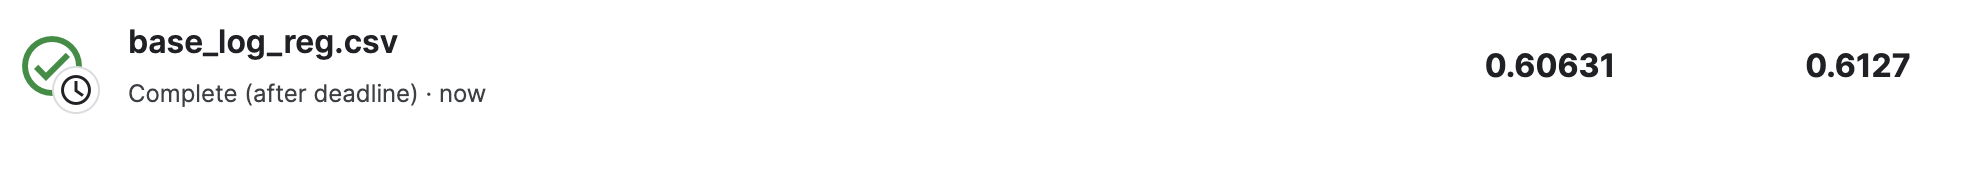

In [ ]:
# create_baseline(all_model["base"], "rf_classifier",rf_class, "base")


In [ ]:
for data_name in all_data.keys():
    log_reg = LogisticRegression(C = 0.0001,solver='lbfgs', max_iter=1000, verbose=0)
    create_baseline(all_data[data_name], "log_reg",log_reg, data_name)

Model log_reg fit: 1.97s, predict: 0.00s, mse: 0.4146
Model log_reg fit: 2.07s, predict: 0.00s, mse: 0.4142
Model log_reg fit: 2.07s, predict: 0.00s, mse: 0.4147
Model log_reg fit: 1.90s, predict: 0.00s, mse: 0.4145
Model log_reg fit: 1.47s, predict: 0.00s, mse: 0.4142
Model log_reg fit: 0.19s, predict: 0.00s, mse: 0.3753
Model log_reg fit: 0.09s, predict: 0.00s, mse: 0.5012
Model log_reg fit: 0.18s, predict: 0.00s, mse: 0.3756
Model log_reg fit: 0.07s, predict: 0.00s, mse: 0.5012
Model log_reg fit: 0.26s, predict: 0.01s, mse: 0.3779
Model log_reg fit: 0.06s, predict: 0.01s, mse: 0.5012
Model log_reg fit: 0.30s, predict: 0.00s, mse: 0.3755
Model log_reg fit: 0.07s, predict: 0.01s, mse: 0.5012
Model log_reg fit: 0.21s, predict: 0.00s, mse: 0.3785
Model log_reg fit: 0.05s, predict: 0.00s, mse: 0.5012


In [ ]:
# create_baseline(all_model["base"], "rf_classifier",rf_class, "base")

for data_name in all_data.keys():
    rf_class = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose=0, n_jobs=6)
    create_baseline(all_data[data_name], "rf_class",rf_class, data_name)

Model rf_class fit: 2.27s, predict: 0.06s, mse: 0.3296
Model rf_class fit: 1.62s, predict: 0.05s, mse: 0.3190
Model rf_class fit: 2.01s, predict: 0.05s, mse: 0.3283
Model rf_class fit: 2.10s, predict: 0.05s, mse: 0.3275
Model rf_class fit: 1.59s, predict: 0.05s, mse: 0.3192
Model rf_class fit: 2.04s, predict: 0.05s, mse: 0.3297
Model rf_class fit: 0.25s, predict: 0.01s, mse: 0.4429
Model rf_class fit: 1.52s, predict: 0.05s, mse: 0.3190
Model rf_class fit: 0.22s, predict: 0.01s, mse: 0.4399
Model rf_class fit: 2.01s, predict: 0.05s, mse: 0.3278
Model rf_class fit: 0.31s, predict: 0.01s, mse: 0.4337
Model rf_class fit: 2.17s, predict: 0.05s, mse: 0.3275
Model rf_class fit: 0.26s, predict: 0.02s, mse: 0.4422
Model rf_class fit: 1.54s, predict: 0.05s, mse: 0.3184
Model rf_class fit: 0.22s, predict: 0.04s, mse: 0.4370


In [ ]:
all_data["default"]["df_aligned"].shape
# all_data["default"]["rf_class"].feature_importances_.shape

(49650, 235)

In [ ]:
check_feature_importances(all_data["default"]).head(10)

feature  importance
31            EXT_SOURCE_3    0.064656
30            EXT_SOURCE_2    0.063647
9            DAYS_EMPLOYED    0.035719
29            EXT_SOURCE_1    0.031972
11         DAYS_ID_PUBLISH    0.031464
10       DAYS_REGISTRATION    0.031060
79  DAYS_LAST_PHONE_CHANGE    0.030434
6              AMT_ANNUITY    0.030251
5               AMT_CREDIT    0.029414
7          AMT_GOODS_PRICE    0.027426

In [ ]:
check_feature_importances(all_data["default"]).head(10)

feature  importance
31            EXT_SOURCE_3    0.064656
30            EXT_SOURCE_2    0.063647
9            DAYS_EMPLOYED    0.035719
29            EXT_SOURCE_1    0.031972
11         DAYS_ID_PUBLISH    0.031464
10       DAYS_REGISTRATION    0.031060
79  DAYS_LAST_PHONE_CHANGE    0.030434
6              AMT_ANNUITY    0.030251
5               AMT_CREDIT    0.029414
7          AMT_GOODS_PRICE    0.027426

In [ ]:
check_feature_importances(all_data["sum_flag_living_contact"]).head(10)

feature  importance
24            EXT_SOURCE_2    0.077452
25            EXT_SOURCE_3    0.075580
9            DAYS_EMPLOYED    0.042975
11         DAYS_ID_PUBLISH    0.041725
10       DAYS_REGISTRATION    0.041157
6              AMT_ANNUITY    0.039816
30  DAYS_LAST_PHONE_CHANGE    0.038861
23            EXT_SOURCE_1    0.038518
5               AMT_CREDIT    0.038139
7          AMT_GOODS_PRICE    0.035265

In [ ]:
check_feature_importances(all_data["sum_flag_living_contact_norm_col"]).head(10)

feature  importance
24            EXT_SOURCE_2    0.077452
25            EXT_SOURCE_3    0.075580
9            DAYS_EMPLOYED    0.042975
11         DAYS_ID_PUBLISH    0.041725
10       DAYS_REGISTRATION    0.041157
6              AMT_ANNUITY    0.039816
30  DAYS_LAST_PHONE_CHANGE    0.038861
23            EXT_SOURCE_1    0.038518
5               AMT_CREDIT    0.038139
7          AMT_GOODS_PRICE    0.035265

In [ ]:
check_feature_importances(all_data["sum_flag_living_contact_norm_all"]).head(10)

feature  importance
7          AMT_GOODS_PRICE    0.214290
5               AMT_CREDIT    0.166184
10       DAYS_REGISTRATION    0.154818
9            DAYS_EMPLOYED    0.113595
6              AMT_ANNUITY    0.107381
30  DAYS_LAST_PHONE_CHANGE    0.071977
11         DAYS_ID_PUBLISH    0.059528
4         AMT_INCOME_TOTAL    0.057076
12             OWN_CAR_AGE    0.034912
13         CNT_FAM_MEMBERS    0.016153

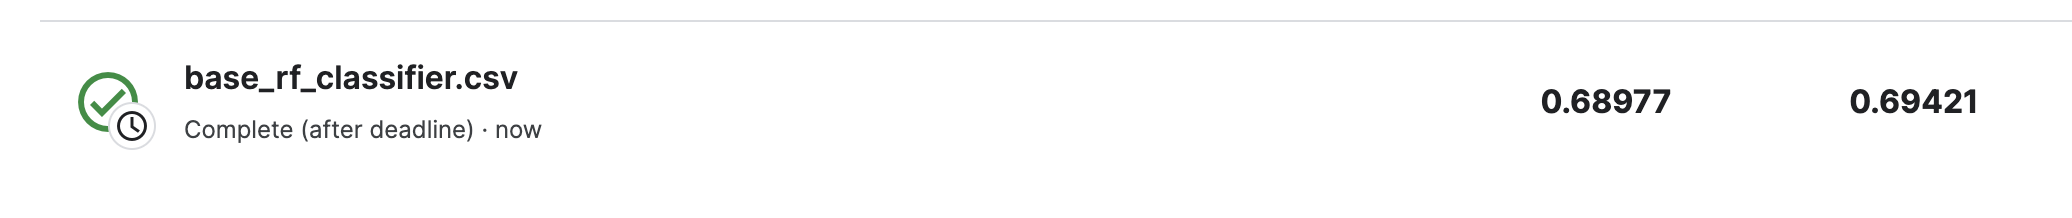

In [ ]:
for data_name in all_data.keys():
    xgb_class = XGBClassifier(random_state=0)
    create_baseline(all_data[data_name], "xgb_class",xgb_class, data_name)

Model xgb_class fit: 0.77s, predict: 0.02s, mse: 0.3148
Model xgb_class fit: 0.53s, predict: 0.01s, mse: 0.3189
Model xgb_class fit: 0.61s, predict: 0.02s, mse: 0.3196
Model xgb_class fit: 0.76s, predict: 0.02s, mse: 0.3157
Model xgb_class fit: 0.47s, predict: 0.01s, mse: 0.3206
Model xgb_class fit: 0.66s, predict: 0.02s, mse: 0.3148
Model xgb_class fit: 0.65s, predict: 0.02s, mse: 0.3196
Model xgb_class fit: 0.51s, predict: 0.01s, mse: 0.3189
Model xgb_class fit: 0.50s, predict: 0.02s, mse: 0.3213
Model xgb_class fit: 0.60s, predict: 0.02s, mse: 0.3196
Model xgb_class fit: 0.58s, predict: 0.02s, mse: 0.3114
Model xgb_class fit: 0.64s, predict: 0.02s, mse: 0.3157
Model xgb_class fit: 0.63s, predict: 0.02s, mse: 0.3180
Model xgb_class fit: 0.57s, predict: 0.01s, mse: 0.3206
Model xgb_class fit: 0.62s, predict: 0.01s, mse: 0.3166


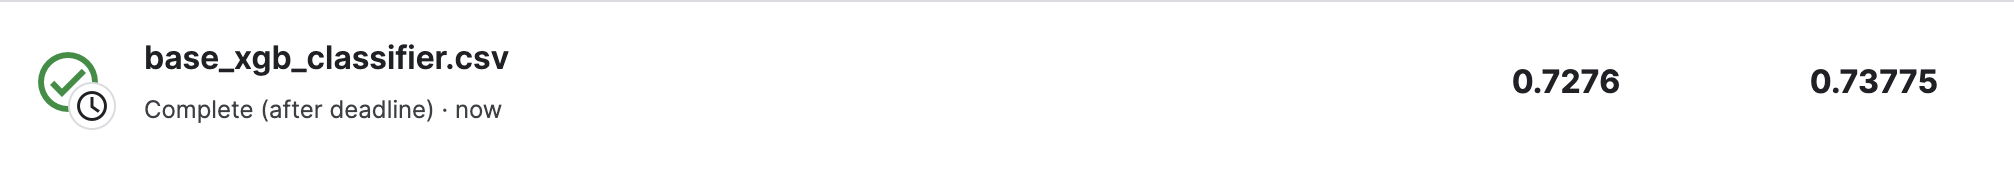

In [ ]:
for data_name in all_data.keys():
    nn_model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(len(all_data[data_name]["X_train"].columns),))
    ])

    nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    create_baseline(all_data[data_name], "nn_model",nn_model, data_name)

1524/1524 [==============================] - 0s 242us/step
Model nn_model fit: 4.13s, predict: 0.20s, mse: 0.4978
1524/1524 [==============================] - 0s 241us/step
Model nn_model fit: 4.00s, predict: 0.17s, mse: 0.4036
1524/1524 [==============================] - 0s 238us/step
Model nn_model fit: 3.69s, predict: 0.17s, mse: 0.4999
1524/1524 [==============================] - 0s 243us/step
Model nn_model fit: 4.12s, predict: 0.18s, mse: 0.4981
1524/1524 [==============================] - 0s 239us/step
Model nn_model fit: 3.95s, predict: 0.16s, mse: 0.5012
1524/1524 [==============================] - 0s 241us/step
Model nn_model fit: 4.05s, predict: 0.17s, mse: 0.2057
1524/1524 [==============================] - 0s 236us/step
Model nn_model fit: 3.95s, predict: 0.15s, mse: 0.2498
1524/1524 [==============================] - 0s 238us/step
Model nn_model fit: 3.96s, predict: 0.16s, mse: 0.2049
1524/1524 [==============================] - 0s 302us/step
Model nn_model fit: 3.93s, pr

In [ ]:
kaggle_results = pd.read_csv("./submissions/result.txt")
model_names = ["log_reg", "xgb_class", "rf_class"]
# model_names = ["log_reg", "xgb_class", "rf_class", "nn_model"]

# Initialize empty lists for data  
data = { 'name': [] }
data_2d_local = { 'name': [], "mse":[] }
data_2d_kaggle = { 'name': [], "score":[] }

local_cols = []
kaggle_cols = []


# Print DataFrame
for data_name in all_data.keys():
    
    data["name"].append(data_name)
    
    for model_name in model_names:
        mse = all_data[data_name][f"{model_name}_mse"]
        key = f"local_{model_name}"
        kkey = f"kaggle_{model_name}"
        
        if key not in data:
            local_cols.append(key)
            data[key] = []
        
        if kkey not in data:
            kaggle_cols.append(kkey)
            data[kkey] = []
        
        
        data[key].append(mse)
        kaggle_score = kaggle_results[kaggle_results["fileName"] == f"{data_name}_{model_name}.csv"]["privateScore"].values[0]
        data[kkey].append(kaggle_score)
        
        data_2d_local["name"].append(f"{data_name}_{model_name}")
        data_2d_local["mse"].append(mse)
        
        data_2d_kaggle["name"].append(f"{data_name}_{model_name}")
        data_2d_kaggle["score"].append(kaggle_score)

stats = pd.DataFrame(data)
stats = stats.reset_index(drop=True)

data_2d_local = pd.DataFrame(data_2d_local)
data_2d_kaggle = pd.DataFrame(data_2d_kaggle)


In [ ]:
local_cols

['local_log_reg', 'local_xgb_class', 'local_rf_class']

In [ ]:
stats.head(15)

name  local_log_reg  kaggle_log_reg  \
0                            default       0.414602         0.60717   
1                sum_living_features       0.414199         0.60717   
2                 sum_flag_documents       0.414703         0.60718   
3                  sum_flag_contacts       0.414502         0.60718   
4            sum_flag_living_contact       0.414199         0.60717   
5                   default_norm_col       0.375327         0.67850   
6                   default_norm_all       0.501208         0.50752   
7       sum_living_features_norm_col       0.375629         0.67809   
8       sum_living_features_norm_all       0.501208         0.50752   
9        sum_flag_documents_norm_col       0.377946         0.67956   
10       sum_flag_documents_norm_all       0.501208         0.50752   
11        sum_flag_contacts_norm_col       0.375529         0.67909   
12        sum_flag_contacts_norm_all       0.501208         0.50752   
13  sum_flag_living_contact_norm_col       0.378550         0.67987   
14  sum_flag_living_contact_norm_all       0.501208         0.50752   

    local_xgb_class  kaggle_xgb_class  local_rf_class  kaggle_rf_class  
0          0.314804           0.72948        0.329607          0.69125  
1          0.318933           0.73039        0.319033          0.69980  
2          0.319637           0.72942        0.328298          0.69107  
3          0.315710           0.72991        0.327492          0.68820  
4          0.320645           0.72990        0.319235          0.69871  
5          0.314804           0.68616        0.329708          0.65947  
6          0.319637           0.45296        0.442900          0.51090  
7          0.318933           0.68459        0.319033          0.67053  
8          0.321349           0.49519        0.439879          0.53714  
9          0.319637           0.69034        0.327795          0.65794  
10         0.311380           0.45974        0.433736          0.50743  
11         0.315710           0.69016        0.327492          0.65138  
12         0.318026           0.45851        0.442195          0.50641  
13         0.320645           0.68712        0.318429          0.65280  
14         0.316616           0.45519        0.436959          0.49492

/Users/m/dev/6be709c0/oc-ai-engineer/OC/P4/output/helpers.py:451: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


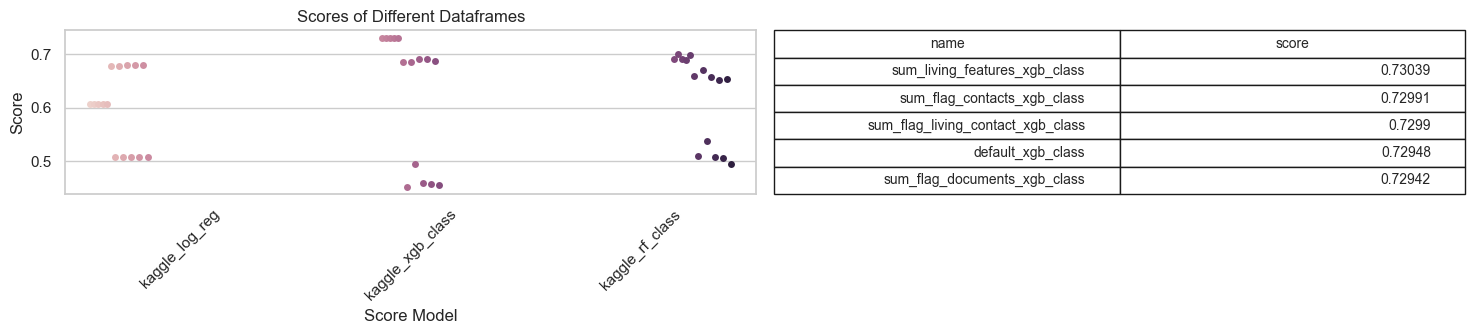

In [ ]:
show_graph_kaggle(stats[kaggle_cols], data_2d_kaggle)

/Users/m/dev/6be709c0/oc-ai-engineer/OC/P4/output/helpers.py:420: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)


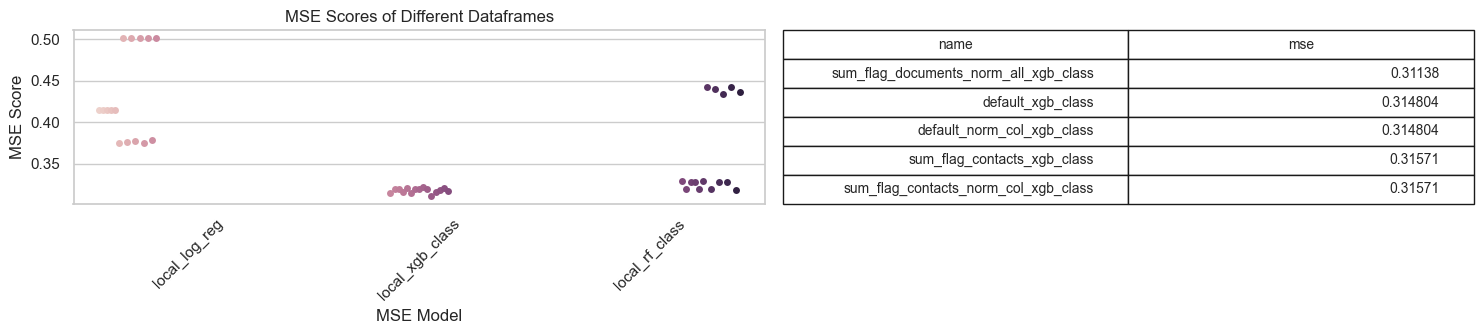

In [ ]:
show_graph_local(stats[local_cols], data_2d_local)
# show_graph_local(stats[stats["local_nn_model"] < 0.5][local_cols], data_2d_local)

---

In [ ]:
print(f"Good customer = {len(app_train[app_train['TARGET'] == 0])}")
print(f"Bad customer = {len(app_train[app_train['TARGET'] == 1])}")

Good customer = 24825
Bad customer = 24825


In [ ]:

print(f"Good customer = {len(all_data['default']['df'][all_data['default']['df']['TARGET'] == 0])}")
print(f"Bad customer = {len(all_data['default']['df'][all_data['default']['df']['TARGET'] == 1])}")


Good customer = 24825
Bad customer = 24825


In [ ]:
# Keeping sum_living_features_xgb_class


In [ ]:
dataFrame = all_data['sum_living_features']
xgb_class = XGBClassifier(random_state=0)

param_grid = {  
    'max_depth': [3, 5, 7],  
    'learning_rate': [0.01, 0.1, 0.5],  
    'n_estimators': [100, 500, 1000]  
}
grid_search = GridSearchCV(estimator=xgb_class,scoring='neg_mean_squared_error', param_grid=param_grid, cv=3)  
grid_search.fit(dataFrame["X_train"],dataFrame["y_train"])  


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=0, ...),
             param_grid={'learning_rate': [0.01, 0.1, 0.5],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 500, 1000]},
             scoring='neg_mean_squared_error')

In [ ]:

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best params: {best_params}")
print(f"Best score: {-best_score}")

Best params: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}
Best score: 0.31842900302114807


In [ ]:
# dataFrame = all_data['sum_living_features']

xgb_class = XGBClassifier(random_state=0, **best_params)

create_baseline(dataFrame, "xgb_class_best",xgb_class, 'sum_living_features')

Model xgb_class_best fit: 1.44s, predict: 0.02s, mse: 0.3088


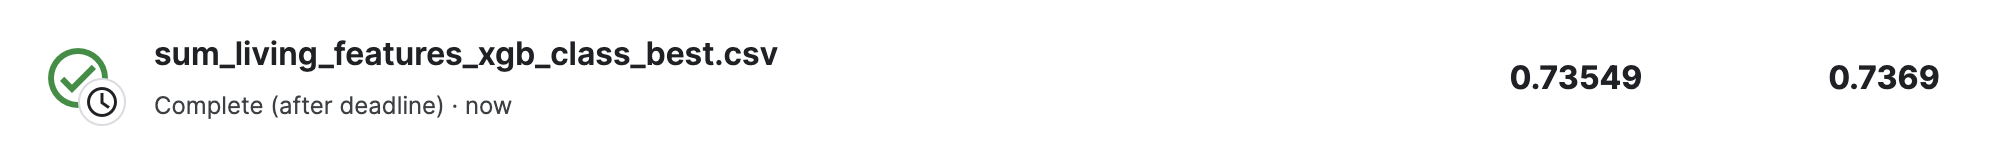

In [ ]:
fn, fp, tp, tn = get_false_negatives_false_positives(dataFrame["y_test"], dataFrame["xgb_class_best_pred"])
print(tp, fp)
print(fn, tn)

NameError: name 'get_false_negatives_false_positives' is not defined

In [ ]:
nn_model = tf.keras.Sequential([  
    tf.keras.layers.Dense(256, activation='relu', input_shape=(len(dataFrame["X_train"].columns),)),  
    tf.keras.layers.Dropout(0.1),  # Adding dropout regularization  
    tf.keras.layers.Dense(128, activation='relu'),  
    tf.keras.layers.Dropout(0.3),  # Adding dropout regularization  
    tf.keras.layers.Dense(1, activation='sigmoid')  
])  
  
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = nn_model.fit(dataFrame["X_train"], dataFrame["y_train"], epochs=10, batch_size=32)  

Epoch 1/10
1242/1242 [==============================] - 1s 728us/step - loss: 1192.8219 - accuracy: 0.5048
Epoch 2/10
1242/1242 [==============================] - 1s 793us/step - loss: 4.3005 - accuracy: 0.4976
Epoch 3/10
1242/1242 [==============================] - 1s 741us/step - loss: 5.4352 - accuracy: 0.4963
Epoch 4/10
1242/1242 [==============================] - 1s 772us/step - loss: 1.3305 - accuracy: 0.4988
Epoch 5/10
1242/1242 [==============================] - 1s 751us/step - loss: 1.2736 - accuracy: 0.4990
Epoch 6/10
1242/1242 [==============================] - 1s 683us/step - loss: 1.5588 - accuracy: 0.4960
Epoch 7/10
1242/1242 [==============================] - 1s 719us/step - loss: 1.2102 - accuracy: 0.5003
Epoch 8/10
1242/1242 [==============================] - 1s 711us/step - loss: 1.4512 - accuracy: 0.4982
Epoch 9/10
1242/1242 [==============================] - 1s 747us/step - loss: 0.9659 - accuracy: 0.4985
Epoch 10/10
1242/1242 [==============================] - 1s 7

In [ ]:
y_pred = nn_model.predict(dataFrame["X_test"])  

311/311 [==============================] - 0s 334us/step


In [ ]:
mean_squared_error(y_pred, dataFrame["y_test"])

0.24999896579378755

In [ ]:
y_pred_2 = nn_model.predict(dataFrame["test_df_aligned"])  


1524/1524 [==============================] - 0s 320us/step


In [ ]:
prepare_submission(dataFrame, y_pred_2, "nn_model_improved32")

In [ ]:
nn_model = tf.keras.Sequential([  
    tf.keras.layers.Dense(256, activation='relu', input_shape=(len(dataFrame["X_train"].columns),)),  
    tf.keras.layers.Dropout(0.1),  # Adding dropout regularization  
    tf.keras.layers.Dense(128, activation='relu'),  
    tf.keras.layers.Dropout(0.3),  # Adding dropout regularization  
    tf.keras.layers.Dense(1, activation='sigmoid')  
])  
  
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = nn_model.fit(dataFrame["X_train"], dataFrame["y_train"], epochs=10, batch_size=32)  

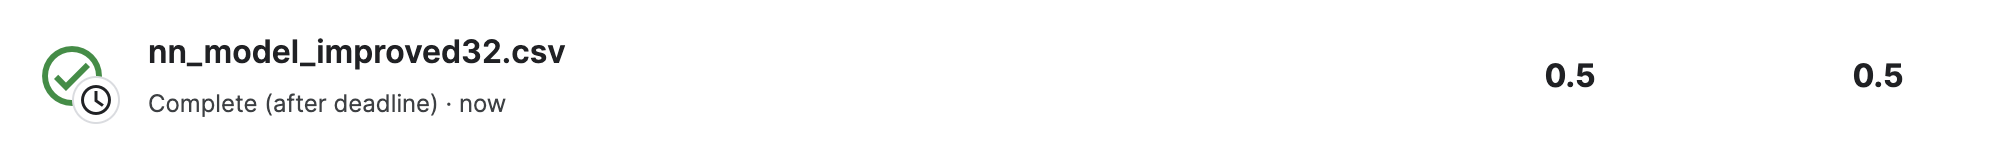

In [ ]:
# from imblearn.under_sampling import RandomUnderSampler

# # dataFrame = all_data['sum_living_features']
# # xgb_class = XGBClassifier(random_state=0)

# # param_grid = {  
# #     'max_depth': [3, 5, 7],  
# #     'learning_rate': [0.01, 0.1, 0.5],  
# #     'n_estimators': [100, 500, 1000]  
# # }
# # grid_search = GridSearchCV(estimator=xgb_class,scoring='neg_mean_squared_error', param_grid=param_grid, cv=3)  
# # grid_search.fit(dataFrame["X_train"],dataFrame["y_train"])

# print(f"Before undersampling: {len(dataFrame['y_train'][dataFrame['y_train'] == 0])}")
# print(f"Before undersampling: {len(dataFrame['y_train'][dataFrame['y_train'] == 1])}")

# random_sampler = RandomUnderSampler(
#     sampling_strategy=1.0,  # perfect balance
#     random_state=42,
# )

# X_train, y_train = random_sampler.fit_resample(dataFrame["X_train"], dataFrame["y_train"])

# print(f"After undersampling: {len(y_train[y_train == 0])}")
# print(f"After undersampling: {len(y_train[y_train == 1])}")


In [ ]:
best_params

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 500}

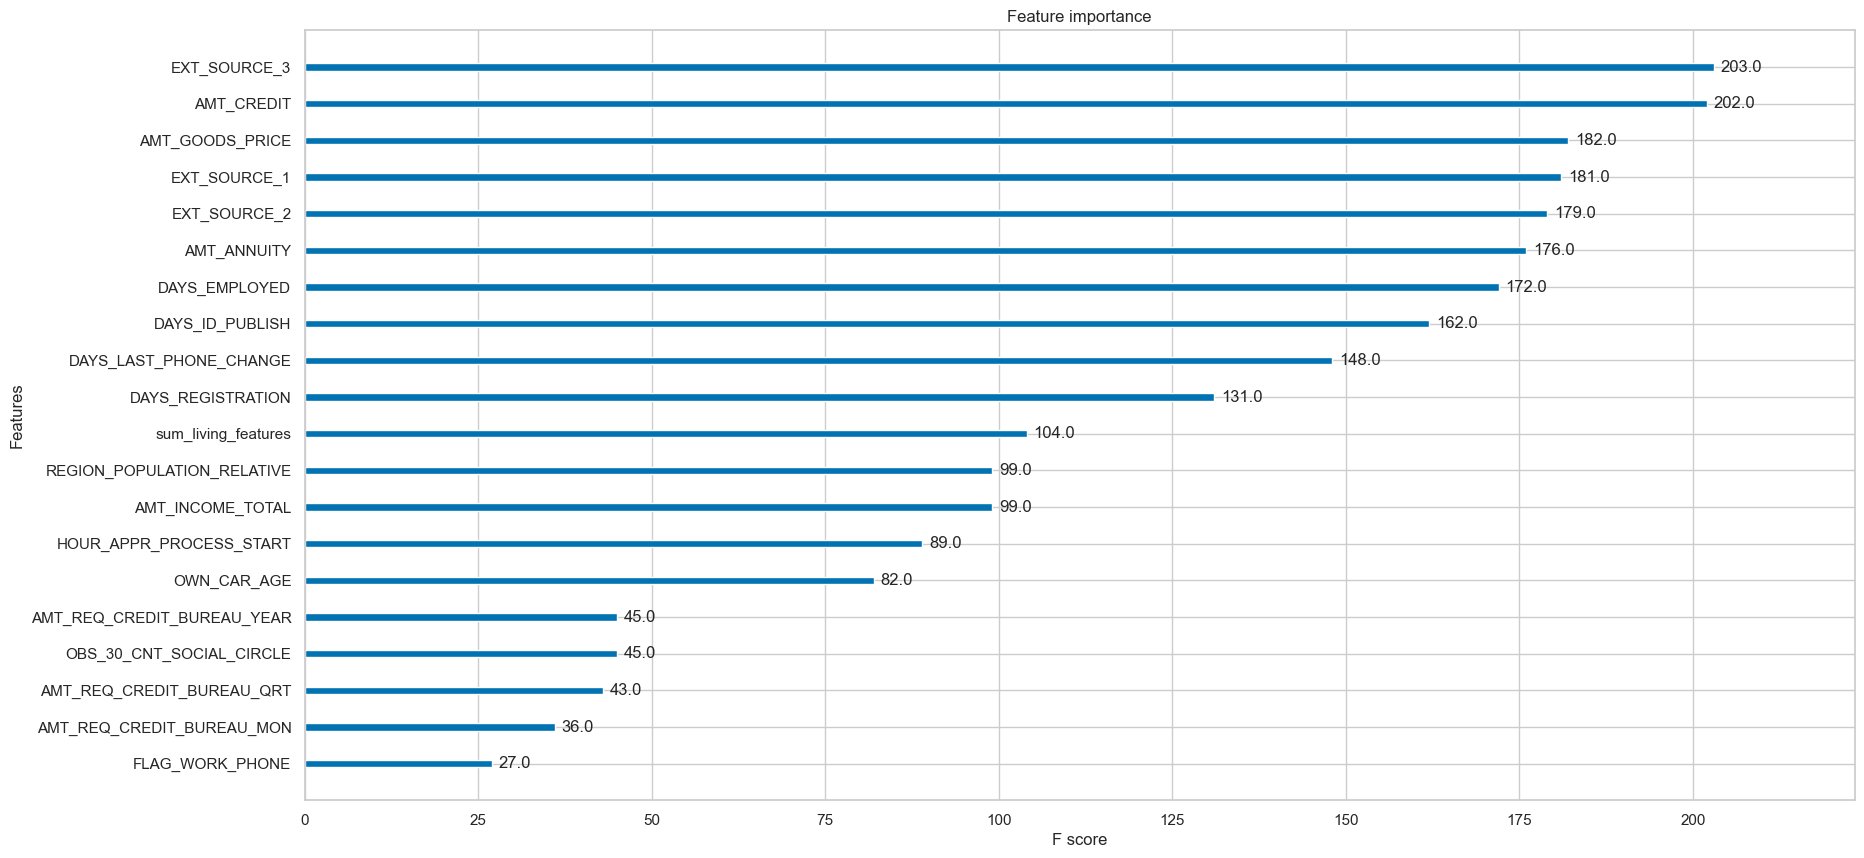

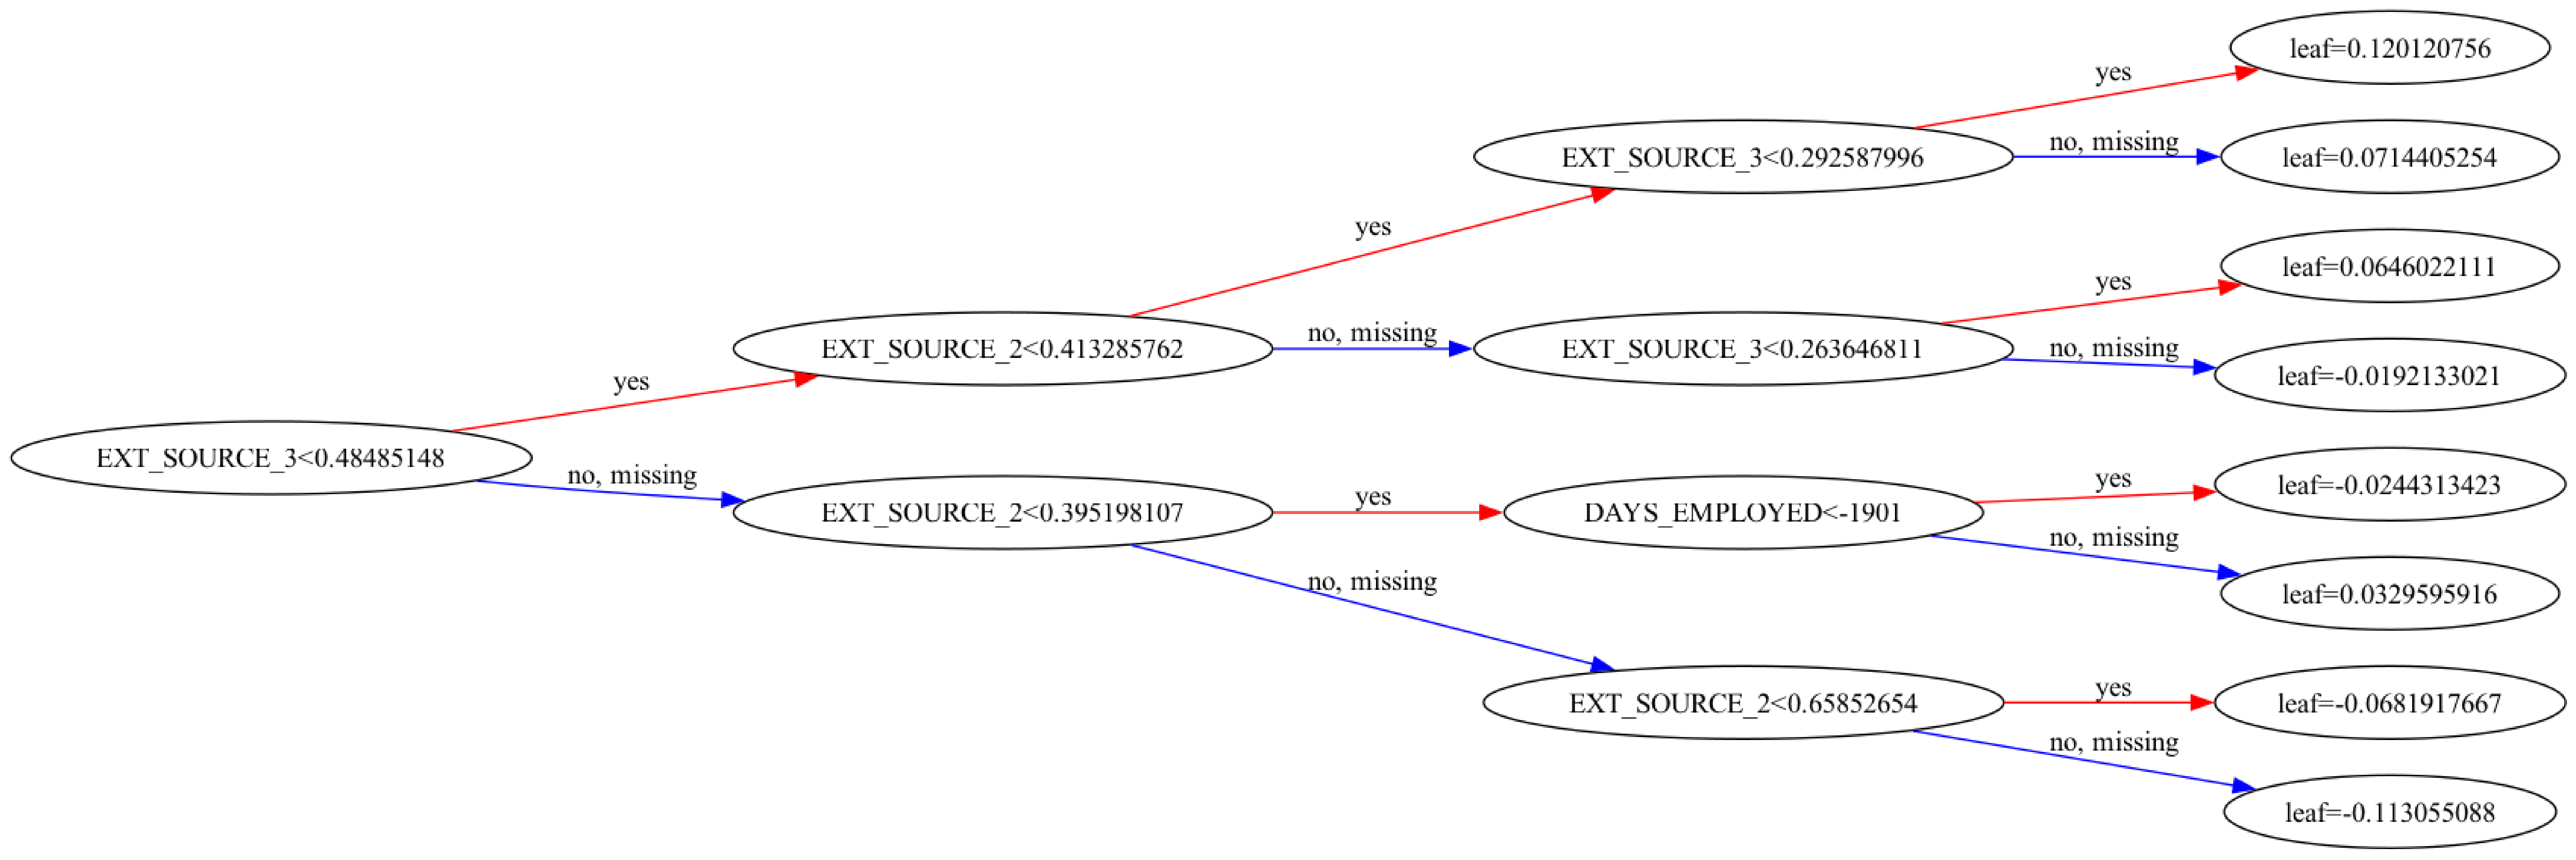

In [ ]:
# Plot feature importance
xgb_plot_importance(
    booster=dataFrame["xgb_class_best"],
    max_num_features=20,
)
fig = plt.gcf()
fig.set_size_inches(20, 10)


# Plot tree
xgb_plot_tree(booster=dataFrame["xgb_class_best"], rankdir="LR")
fig = plt.gcf()
fig.set_size_inches(100, 50)


In [ ]:
print(f"True value = {dataFrame['y_test'].iloc[68]}")


True value = 0


In [ ]:
print(f"True value = {dataFrame['y_test'].iloc[68]}")
check_sample(dataFrame, 23).show_in_notebook()

True value = 0


In [ ]:
print(f"True value = {dataFrame['y_test'].iloc[5]}")
check_sample(dataFrame,5).show_in_notebook()

# random_sample = 120
# found = True
# while found:
#     exp = check_sample(random_sample)
#     if(exp.predict_proba[1] >= 0.3 and all_data['sum_living_features']['y_test'].iloc[random_sample] == 1):
#         found = False
#         print(f"True value ({random_sample}) = {all_data['sum_living_features']['y_test'].iloc[random_sample]}")
#         exp.show_in_notebook()
#     random_sample +=1
    

True value = 1


In [ ]:
# Weigh accuracy (scorer between 0 and 100)